# Develop simulation of strand length 

Choose the actual number of breaks for a given strand using a Poisson distribution and the mean number of breaks per strand. Assume the breaks are uniformly distributed along each strand. Calculate the distance between breaks (the segment lengths) by sorting the breaks according to distance along the strand then subtracting successive break positions. Add the first and and last segment lengths (zero to first sorted break, last sorted break to strand length, respectively).   



In [4]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

Date and time  2023-05-09 09:50:20.133021
 
Conversion from bp to cm 4.00e-08
Conversion from bp to microns 4.00e-04


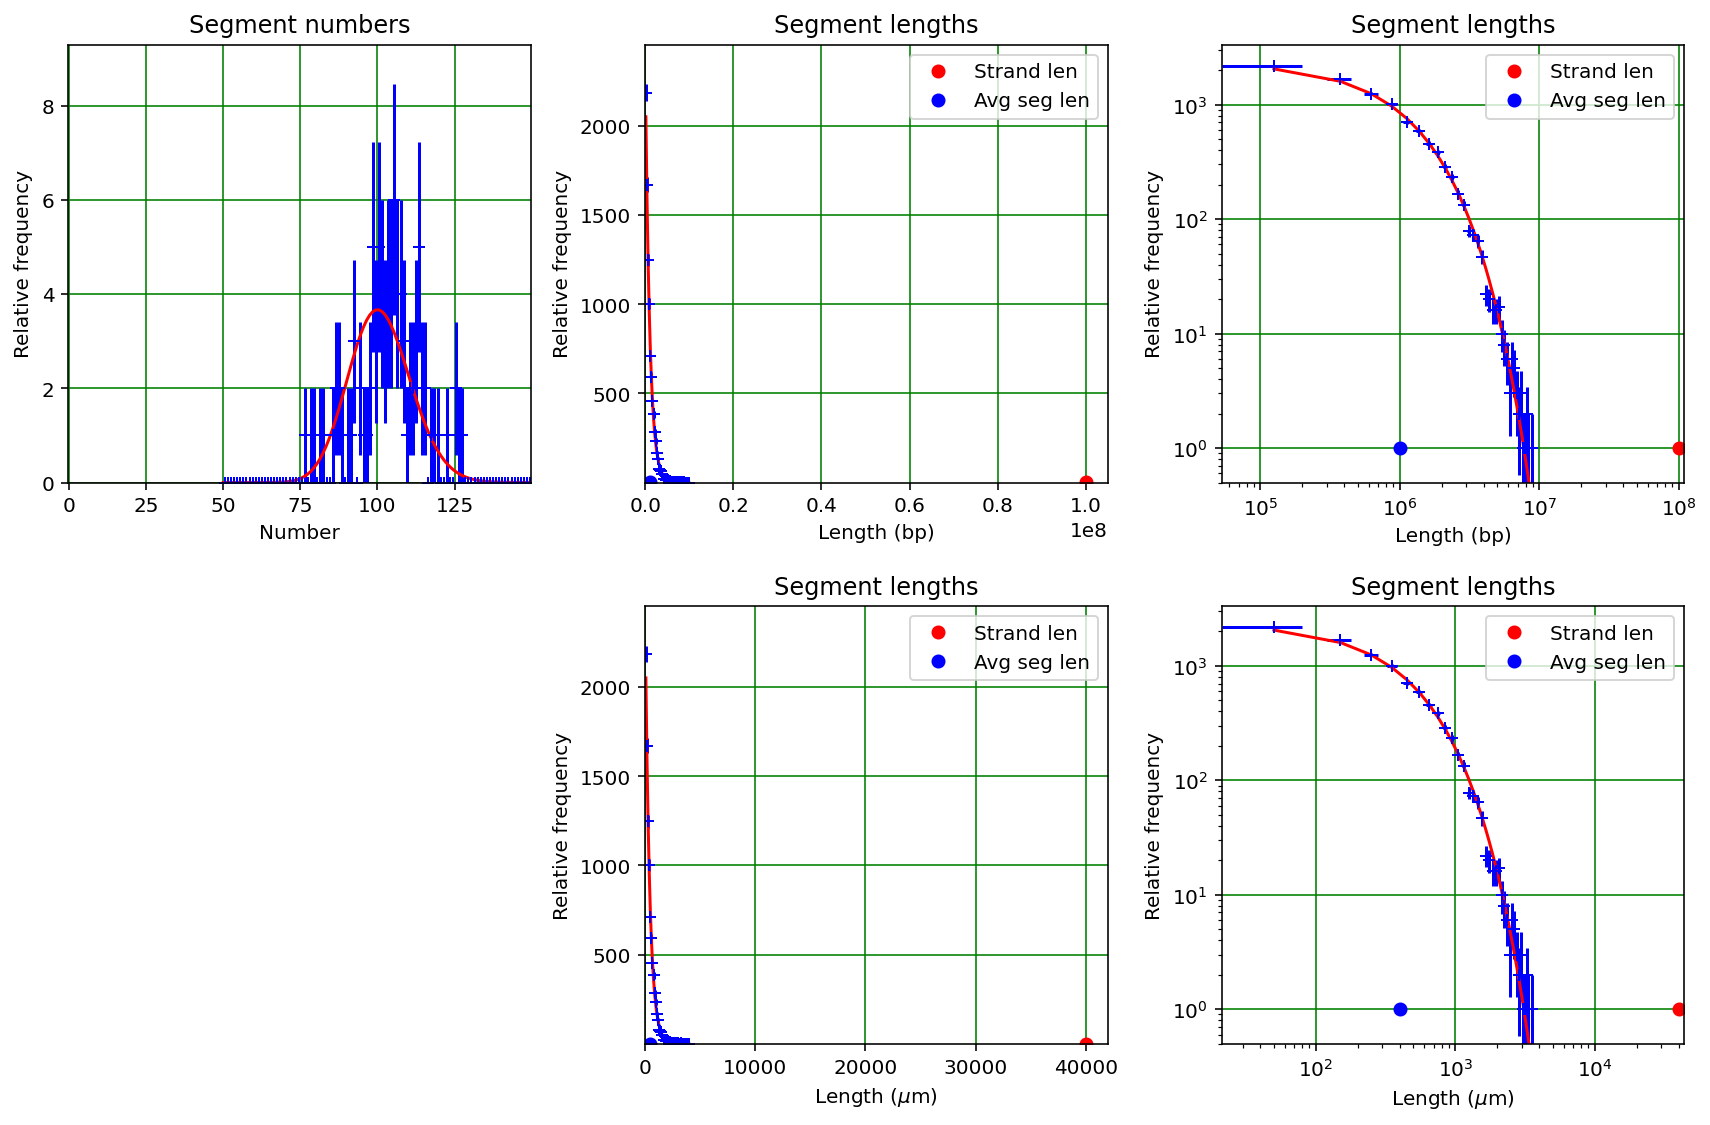

In [16]:
now = datetime.datetime.now()
print("Date and time ",str(now))
#
def poisson_func(k, lam):
    '''
    Poisson distribution function.
    Given number of occurences and mean, returns distribution function value.
    '''
    poiss = lam**k*np.exp(-lam)/special.factorial(k)
    return poiss
#
def break_strands(n_strands, mean_breaks):
    '''
    Given number of DNA strands in cell and mean number of breaks per strand, return number of segments 
    each strand breaks into and the lengths of those segments in base-pairs.
    '''
    n_segs = np.zeros(n_strands).astype(int)
    seg_lens = np.zeros((n_strands, (mean_breaks + 5*np.sqrt(mean_breaks)).astype(int)))
    #
    for n in range(0, n_strands):
        n_breaks = rng.poisson(mean_breaks)
        breaks = np.zeros(n_breaks)
        breaks = rng.uniform(0.0, 1.0, n_breaks)
        n_segs[n] = n_breaks + 1
        ends = np.zeros(n_segs[n] + 1)
        ends[1:n_segs[n]] = np.sort(breaks)
        ends[n_segs[n]] = 1.0
        seg_lens[n, 0:n_segs[n]] = L_DNA_bp*(ends[1:n_segs[n] + 1] - ends[0:n_segs[n]])
    #
    return n_segs, seg_lens
#
bp_to_cm = 100*0.04/1e8
bp_to_mum = 1e6*0.04/1e8
print(" ")
print(f"Conversion from bp to cm {bp_to_cm:.2e}")
print(f"Conversion from bp to microns {bp_to_mum:.2e}")
#
# Number of (single) DNA strands
n_strands = 92
#
# Length of DNA strand
L_DNA_bp = 1e8 # base pairs
L_DNA_cm = 4.0 # cm
#
# Define image parameters and agarose depth
n_rows = 1040 # number of rows of pixels (y coord)
n_cols = 1392 # number of columns of pixels (x coord)
depth = 20 # depth of agarose in case optical simulation needed (z coord)
n_pixels = n_rows*n_cols
#
# Initialise random number generator
rng = np.random.default_rng(123)
#
# Average number of breaks per strand, the number of segments generated and their lengths
mean_breaks = 100 
#mean_breaks = 40
#
# Simulate breaks and segments for all strands
n_segs, seg_lens = break_strands(n_strands, mean_breaks)
#
# Set up histgram of number of breaks
num_range = np.zeros(2)
num_range[0] = np.maximum(mean_breaks - 5*np.sqrt(mean_breaks), 0.0).astype(int)
num_range[1] = (mean_breaks + 5*np.sqrt(mean_breaks)).astype(int)
n_num_bins = ((num_range[1] - num_range[0])).astype(int)
num_bins, num_bin_wid = np.linspace(num_range[0], num_range[1], n_num_bins + 1, retstep = True)
num_bin_cents = 0.5*(num_bins[0:n_num_bins] + num_bins[1:n_num_bins + 1])
num_bin_err = num_bin_wid/np.sqrt(12)*np.ones(n_num_bins)
cum_num_hist = np.zeros(n_num_bins)
#
# Set up histogram of segment lengths
n_len_bins = 40
len_bins, len_bin_wid = np.linspace(0.0, 10*L_DNA_bp/mean_breaks, n_len_bins + 1, retstep = True)
len_bin_cents = 0.5*(len_bins[0:n_len_bins] + len_bins[1:n_len_bins + 1])
len_bin_err = len_bin_wid/np.sqrt(12)*np.ones(n_len_bins)
cum_len_hist = np.zeros(n_len_bins)
#
# Fill histograms
for n in range(0, n_strands):
    #
    num_hist_here, _ = np.histogram(n_segs[n], num_bins)
    cum_num_hist += num_hist_here
    #
    len_hist_here, _ = np.histogram(seg_lens[n, 0:n_segs[n]], len_bins)
    cum_len_hist += len_hist_here
#
# Function describing distribution of number of breaks
n_poiss_plot = 100
k_poiss_plot = np.linspace(num_range[0], num_range[1], n_poiss_plot)
poiss_func_plot = n_strands*num_bin_wid*poisson_func(mean_breaks, k_poiss_plot)
#
# Function describing segment length distribution
len_func_plot = (mean_breaks*(mean_breaks + 1)*n_strands*
                 len_bin_wid/L_DNA_bp*np.exp(-mean_breaks*len_bin_cents/L_DNA_bp))
#
fig, ax = plt.subplots(2, 3, figsize = (12, 8))
#
ax[0, 0].set_title('Segment numbers')
ax[0, 0].errorbar(num_bin_cents, cum_num_hist, xerr = num_bin_err, yerr = np.sqrt(cum_num_hist),
               linestyle = '', marker = '+', color = 'b')
ax[0, 0].plot(k_poiss_plot, poiss_func_plot, linestyle = '-', marker = '', color = 'r')
ax[0, 0].set_xlabel('Number')
ax[0, 0].set_ylabel('Relative frequency')
ax[0, 0].set_xlim(-num_bin_err[0], num_bin_cents[-1] + num_bin_err[-1])
ax[0, 0].set_ylim(0.0, 1.1*(np.amax(cum_num_hist) + np.amax(np.sqrt(cum_num_hist))))
ax[0, 0].grid(color = 'g')
#
ax[0, 1].set_title('Segment lengths')
ax[0, 1].errorbar(len_bin_cents, cum_len_hist, xerr = len_bin_err, yerr = np.sqrt(cum_len_hist),
               linestyle = '', marker = '+', color = 'b')
ax[0, 1].plot(len_bin_cents, len_func_plot, linestyle = '-', marker = '', color = 'r')
ax[0, 1].plot(L_DNA_bp, 1.0, linestyle = '', marker = 'o', color = 'r', label = "Strand len")
ax[0, 1].plot(L_DNA_bp/mean_breaks, 1.0, linestyle = '', marker = 'o', color = 'b', label = "Avg seg len")
ax[0, 1].set_xlabel('Length (bp)')
ax[0, 1].set_ylabel('Relative frequency')
ax[0, 1].set_xlim(-len_bin_err[0], 1.05*L_DNA_bp)
ax[0, 1].set_ylim(0.5, 1.1*(np.amax(cum_len_hist) + np.amax(np.sqrt(cum_len_hist))))
ax[0, 1].legend()
ax[0, 1].grid(color = 'g')
#
ax[0, 2].set_title('Segment lengths')
ax[0, 2].errorbar(len_bin_cents, cum_len_hist, xerr = len_bin_err, yerr = np.sqrt(cum_len_hist),
               linestyle = '', marker = '+', color = 'b')
ax[0, 2].plot(len_bin_cents, len_func_plot, linestyle = '-', marker = '', color = 'r')
ax[0, 2].plot(L_DNA_bp, 1.0, linestyle = '', marker = 'o', color = 'r', label = "Strand len")
ax[0, 2].plot(L_DNA_bp/mean_breaks, 1.0, linestyle = '', marker = 'o', color = 'b', label = "Avg seg len")
ax[0, 2].set_xlabel('Length (bp)')
ax[0, 2].set_ylabel('Relative frequency')
ax[0, 2].set_xlim(len_bin_cents[0] - len_bin_err[0], 1.1*L_DNA_bp)
ax[0, 2].set_ylim(0.5, 1.5*(np.amax(cum_len_hist) + np.amax(np.sqrt(cum_len_hist))))
ax[0, 2].set_xscale('log')
ax[0, 2].set_yscale('log')
ax[0, 2].legend()
ax[0, 2].grid(color = 'g')
#
ax[1, 0].axis('off')
#
ax[1, 1].set_title('Segment lengths')
ax[1, 1].errorbar(len_bin_cents*bp_to_mum, cum_len_hist, xerr = len_bin_err*bp_to_mum, yerr = np.sqrt(cum_len_hist),
                  linestyle = '', marker = '+', color = 'b')
ax[1, 1].plot(len_bin_cents*bp_to_mum, len_func_plot, linestyle = '-', marker = '', color = 'r')
ax[1, 1].plot(L_DNA_bp*bp_to_mum, 1.0, linestyle = '', marker = 'o', color = 'r', label = "Strand len")
ax[1, 1].plot(L_DNA_bp/mean_breaks*bp_to_mum, 1.0, linestyle = '', marker = 'o', color = 'b', label = "Avg seg len")
ax[1, 1].set_xlabel('Length ($\mu$m)')
ax[1, 1].set_ylabel('Relative frequency')
ax[1, 1].set_xlim(-len_bin_err[0]*bp_to_mum, 1.05*L_DNA_bp*bp_to_mum)
ax[1, 1].set_ylim(0.5, 1.1*(np.amax(cum_len_hist) + np.amax(np.sqrt(cum_len_hist))))
ax[1, 1].legend()
ax[1, 1].grid(color = 'g')
#
ax[1, 2].set_title('Segment lengths')
ax[1, 2].errorbar(len_bin_cents*bp_to_mum, cum_len_hist, xerr = len_bin_err*bp_to_mum, yerr = np.sqrt(cum_len_hist),
                  linestyle = '', marker = '+', color = 'b')
ax[1, 2].plot(len_bin_cents*bp_to_mum, len_func_plot, linestyle = '-', marker = '', color = 'r')
ax[1, 2].plot(L_DNA_bp*bp_to_mum, 1.0, linestyle = '', marker = 'o', color = 'r', label = "Strand len")
ax[1, 2].plot(L_DNA_bp/mean_breaks*bp_to_mum, 1.0, linestyle = '', marker = 'o', color = 'b', label = "Avg seg len")
ax[1, 2].set_xlabel('Length ($\mu$m)')
ax[1, 2].set_ylabel('Relative frequency')
ax[1, 2].set_xlim((len_bin_cents[0] - len_bin_err[0])*bp_to_mum, 1.1*L_DNA_bp*bp_to_mum)
ax[1, 2].set_ylim(0.5, 1.5*(np.amax(cum_len_hist) + np.amax(np.sqrt(cum_len_hist))))
ax[1, 2].set_xscale('log')
ax[1, 2].set_yscale('log')
ax[1, 2].legend()
ax[1, 2].grid(color = 'g')
#
plt.tight_layout()
plt.show()

# DNA clumping

Chromosomes are coiled up into roughly spherical structures when not undergoing mitosis. The typical diameter of the sphere is about 3 to 4 $\mu$m. Put one end of each strand inside a sphere of radius 2 $\mu$m. \(The breaks are assumed not to influence this intial structure!\) Nuclear diameter about 20 $\mu$m.


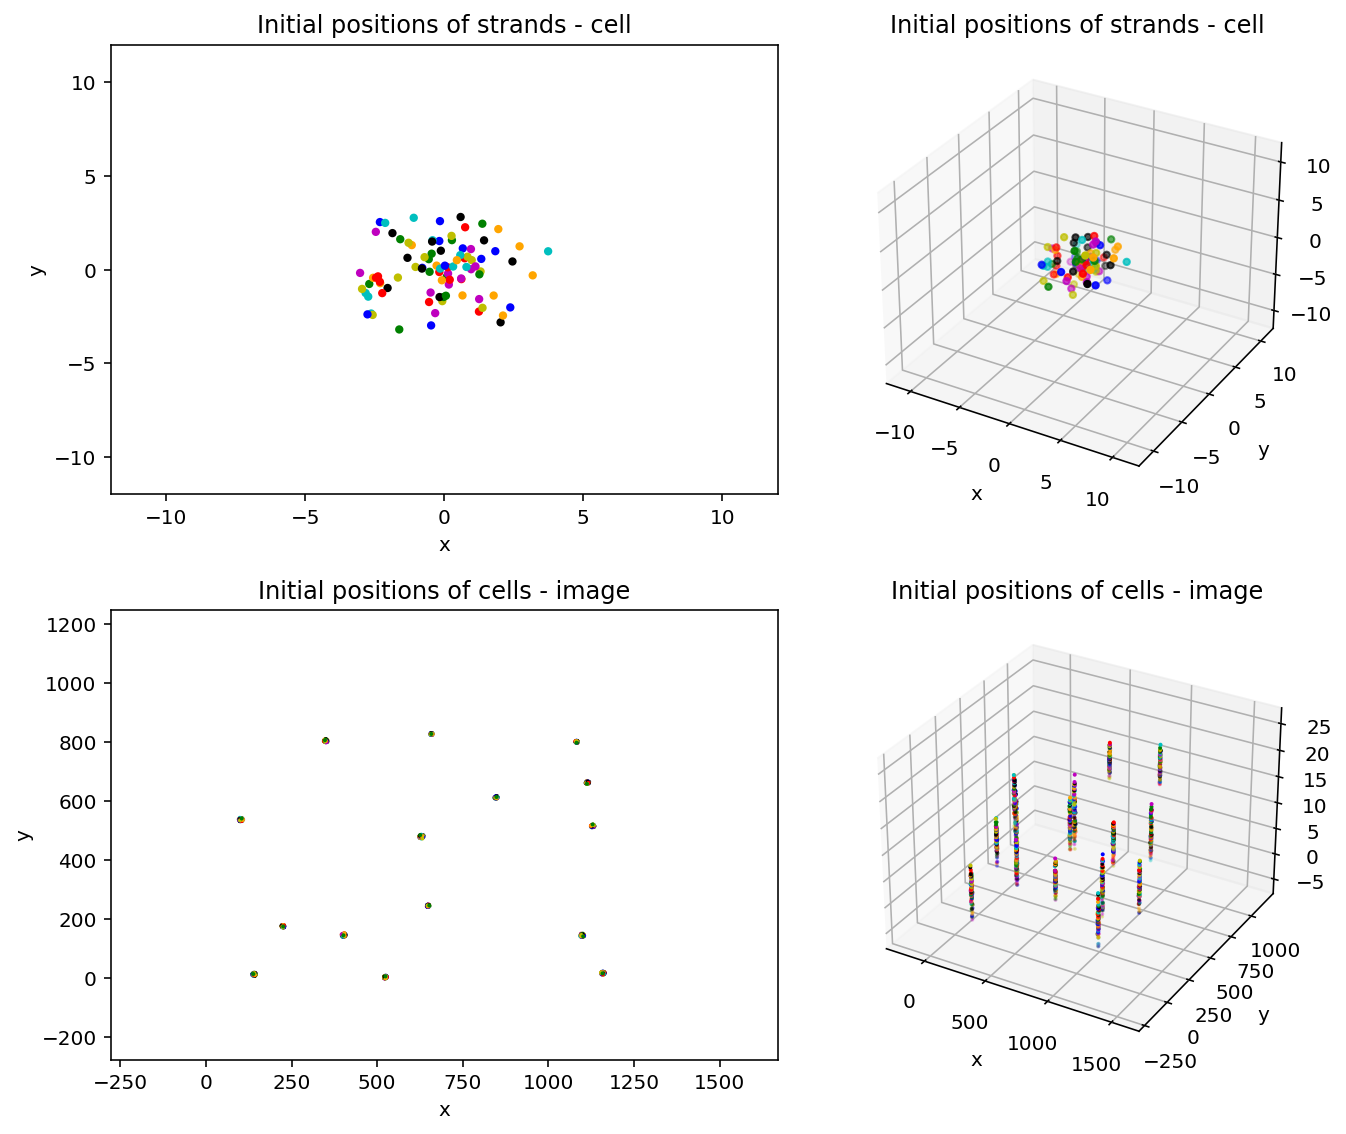

In [17]:
def init_cell_pos(n_cells):
    '''
    Given the number of cells, determine their imitial positions.
    '''
    x_cell = np.zeros(n_cells)
    y_cell = np.zeros(n_cells)
    z_cell = np.zeros(n_cells)
    #
    # Set location of cells
    if n_cells == 1:
        x_cell[0] = n_cols/2
        y_cell[0] = n_rows/2
        z_cell[0] = depth/2
    else:
        x_cell = np.random.uniform(0, n_cols, n_cells)
        y_cell = np.random.uniform(0, n_rows, n_cells)
        z_cell = np.random.uniform(0, depth, n_cells)
    #
    return x_cell, y_cell, z_cell
#
def init_strand_pos(n_strands):
    '''
    Determine the initial positions of the strands within a cell.
    '''
    use_sphere = True
    #
    # Simulate uniform radial and phi initial distribution of strands
    rad_arr = np.sqrt(np.random.uniform(0, max(np.random.normal(rad_cell, sig_rad_cell, 1),
                                               rad_cell_min)**2, n_strands))
    phi_arr = np.random.uniform(0, 2*np.pi, n_strands)
    #
    # Determine initial coordinates of strands (simulate uniform initial theta distribution if required)
    if use_sphere:
        theta_arr = np.arccos(np.random.uniform(-1, 1, n_strands))
        x_strand = rad_arr*np.sin(theta_arr)*np.cos(phi_arr)
        y_strand = rad_arr*np.sin(theta_arr)*np.sin(phi_arr)
        z_strand = rad_arr*np.cos(theta_arr)
    else:
        x_strand = rad_arr*np.cos(phi_arr)
        y_strand = rad_arr*np.sin(phi_arr)
        z_strand = np.random.uniform(0, depth, n_strands)
    #
    return x_strand, y_strand, z_strand
#
# Radius of nucleus
rad_nuc = 2.0 # microns
rad_nuc_min = 1.5 # microns
sig_rad_nuc = 0.5 # microns
#
# Radius of cell
rad_cell = 6.0 # microns
rad_cell_min = 4.0 # microns
sig_rad_cell = 1.0 # microns
#
# Color table for plots
n_color_tab = 8
color_tab = np.array(['r', 'orange', 'y', 'g', 'c', 'b', 'm', 'k'])
#
fig = plt.figure(figsize = (10, 8))
#
ax2d_cell = fig.add_subplot(2, 2, 1)
ax2d_cell.set_title("Initial positions of strands - cell")
ax2d_cell.set_xlabel("x")
ax2d_cell.set_ylabel("y")
#
ax3d_cell = fig.add_subplot(2, 2, 2, projection='3d')
ax3d_cell.set_title("Initial positions of strands - cell")
ax3d_cell.set_xlabel("x")
ax3d_cell.set_ylabel("y")
ax3d_cell.set_zlabel("z")
#
ax2d_pic = fig.add_subplot(2, 2, 3)
ax2d_pic.set_title("Initial positions of cells - image")
ax2d_pic.set_xlabel("x")
ax2d_pic.set_ylabel("y")
#
ax3d_pic = fig.add_subplot(2, 2, 4, projection='3d')
ax3d_pic.set_title("Initial positions of cells - image")
ax3d_pic.set_xlabel("x")
ax3d_pic.set_ylabel("y")
ax3d_pic.set_zlabel("z")
#
# Set up number of cells and their positions
n_cells = 15
x_cell, y_cell, z_cell = init_cell_pos(n_cells)
#
for n_cell in range(0, n_cells):
    #
    # Detemine and plot initial positions of all strands in image
    x_strand, y_strand, z_strand = init_strand_pos(n_strands)
    #
    col_inds = (np.linspace(0, n_strands - 1, n_strands)%n_color_tab).astype(int)
    ax2d_pic.scatter(x_cell[n_cell] + x_strand, 
                     y_cell[n_cell] + y_strand, color = color_tab[col_inds], s = 1.0)
    ax3d_pic.scatter(x_cell[n_cell] + x_strand, 
                     y_cell[n_cell] + y_strand, 
                     z_cell[n_cell] + z_strand, color = color_tab[col_inds], s = 1.0)
    #
    if n_cell > 0:
        continue
    #
    # Plot initial positions of strands in one cell 
    ax2d_cell.scatter(x_strand, y_strand, color = color_tab[col_inds], s = 10.0)
    ax3d_cell.scatter(x_strand, y_strand, z_strand, color = color_tab[col_inds], s = 10.0)    
#
scale_cell = 2.0
ax2d_cell.set_xlim(-scale_cell*rad_cell, scale_cell*rad_cell)
ax2d_cell.set_ylim(-scale_cell*rad_cell, scale_cell*rad_cell)
#
ax3d_cell.set_xlim(-scale_cell*rad_cell, scale_cell*rad_cell)
ax3d_cell.set_ylim(-scale_cell*rad_cell, scale_cell*rad_cell)
ax3d_cell.set_zlim(-scale_cell*rad_cell, scale_cell*rad_cell)
#
expand_pic = 0.2
ax2d_pic.set_xlim(-expand_pic*n_cols, (1 + expand_pic)*n_cols)
ax2d_pic.set_ylim(-expand_pic*n_cols, (1 + expand_pic)*n_rows)
#
ax3d_pic.set_xlim(-expand_pic*n_cols, (1 + expand_pic)*n_cols)
ax3d_pic.set_ylim(-expand_pic*n_cols, (1 + expand_pic)*n_rows)
ax3d_pic.set_zlim(-(1 + expand_pic)*rad_cell, depth + (1 + expand_pic)*rad_cell)
#
plt.tight_layout()
plt.show()

### Motion of DNA in Agarose

This cell uses function vDagarose\(\) to determine velocity of segments for different electric field strengths and segment lengths. Plots of segment length and velocity against relative frequency have also been plotted.


 
Parameters used to descibe vD in agarose
kB = 2.24
kC = 0.56
kL = 0.59
alpha = 1.34


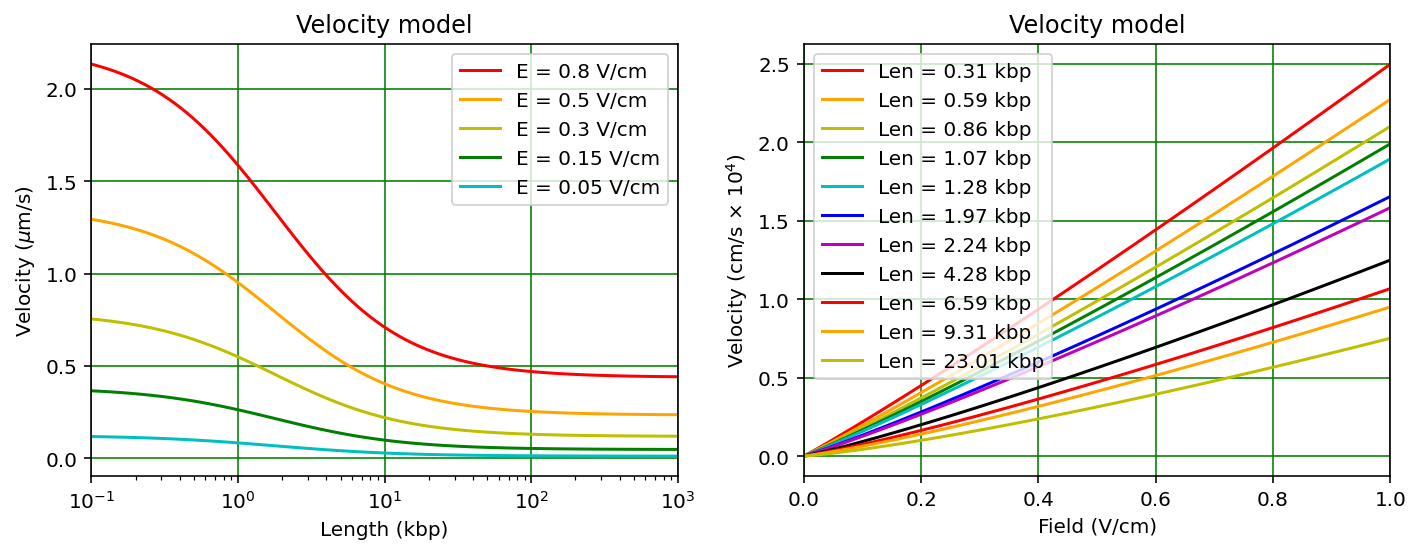

 
Electric field 1.00 V/cm.
Drift time 1800.00 s.
Typical drift velocity 0.93 microns/sec.
Typical drift distance 1672.91 microns.
 


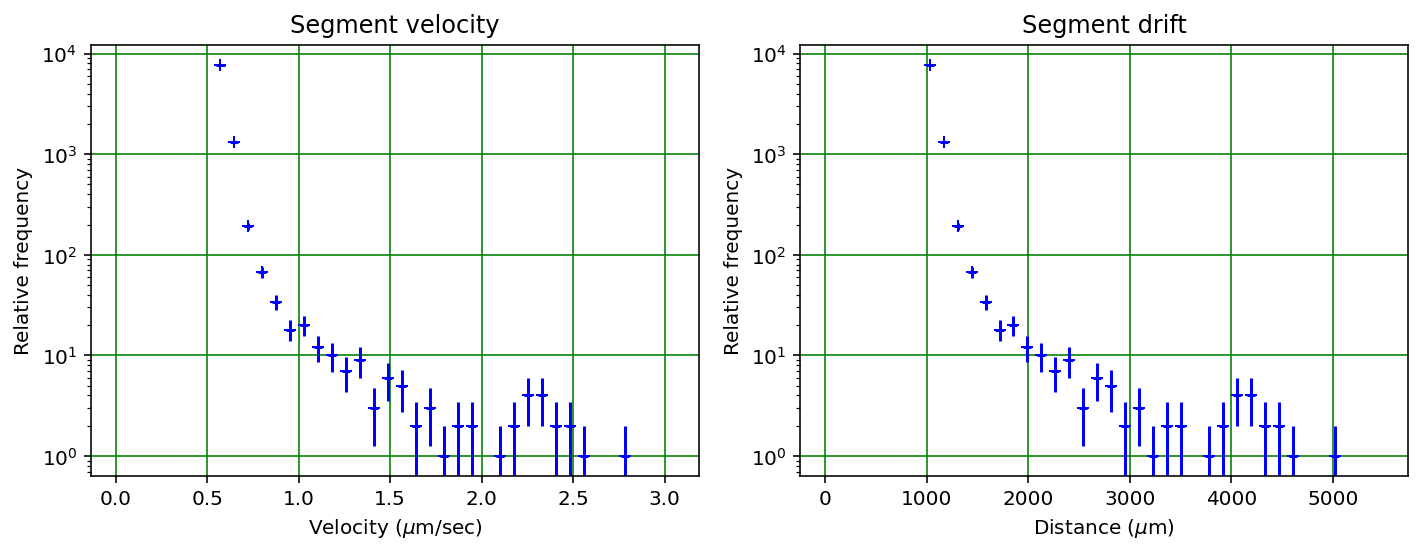

In [18]:
def vDagarose(L, E):
    '''
    Given length of DNA strand (in kbp) and electric field (in V/cm) returns 
    velocity in agarose (units probably microns per sec). Fit to data in Zimm paper.
    '''
    if not hasattr(vDagarose, "kB"):
        vDagarose.kB, vDagarose.kC, vDagarose.kL, vDagarose.alpha = 2.24, 0.56, 0.59, 1.34
        print(" ")
        print("Parameters used to descibe vD in agarose")
        print("kB = {:.2f}".format(vDagarose.kB))
        print("kC = {:.2f}".format(vDagarose.kC))
        print("kL = {:.2f}".format(vDagarose.kL))
        print("alpha = {:.2f}".format(vDagarose.alpha))
    #
    vD = (vDagarose.kB*E/(1 + vDagarose.kC*L) + vDagarose.kL*E**vDagarose.alpha)  # microns per sec.
    #
    return vD
#
def vDagaroseC(L, E):
    '''
    Given length of DNA strand (in kbp) and electric field (in V/cm) returns 
    velocity in agarose (units mm per hour). Fit to data from Calladine paper.
    '''
    if not hasattr(vDagaroseC, "kB"):
        vDagaroseC.kB, vDagaroseC.kC, vDagaroseC.kL, vDagaroseC.alpha = 2.68, 0.83, 5.83, -3.96
        print(" ")
        print("Parameters used to descibe vD in agarose")
        print("kB = {:.2f}".format(vDagaroseC.kB))
        print("kC = {:.2f}".format(vDagaroseC.kC))
        print("kL = {:.2f}".format(vDagaroseC.kL))
        print("alpha = {:.2f}".format(vDagaroseC.alpha))
    #
    vD = (vDagaroseC.kB*E/(1 + vDagaroseC.kC*L) + vDagaroseC.kL*E**vDagaroseC.alpha)  # mm per hour.
    #
    return vD
#
# Calculate fitted function values x direction
nPlot = 100
xBot = 0.1
xTop = 1000.0
xPlot = np.exp(np.linspace(np.log(xBot), np.log(xTop), nPlot))
nY = 5
yVals = np.array([0.05, 0.15, 0.3, 0.5, 0.8]) # V/cm
#
# Calculate fitted function values y direction
yBot = 0.0
yTop = 1.0
yPlot = np.linspace(yBot, yTop, nPlot)
nX = 11
xVals = np.array([0.31, 0.59, 0.86, 1.07, 1.28, 1.97, 2.24, 4.28, 6.59, 9.31, 23.01]) # kbp
#
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Velocity model')
ax.set_xlabel('Length (kbp)')
ax.set_ylabel('Velocity ($\mu$m/s)')
nCol = 0
#
for plot in range(nY, 0, -1):
    fitPlotX = vDagarose(xPlot, yVals[plot - 1]*np.ones(nPlot))
    #fitPlotXC = vDagaroseC(xPlot, yVals[plot - 1]*np.ones(nPlot))
    ax.plot(xPlot, fitPlotX, linestyle = '-', color = color_tab[nCol%n_color_tab], 
            label = "E = " + str(yVals[plot - 1]) + " V/cm")
    #ax.plot(xPlot, fitPlotXC, linestyle = '--', color = color_tab[nCol%n_color_tab])
    nCol += 1
#
ax.set_xlim(xBot, xTop)
#ax.set_ylim(0, 0.75)
ax.set_xscale('log')
ax.grid(color = 'g')
ax.legend()
#
ax = fig.add_subplot(1, 2, 2)
ax.set_title('Velocity model')
ax.set_xlabel('Field (V/cm)')
ax.set_ylabel('Velocity (cm/s $\\times$ $10^4$)')
nCol = 0
#
for plot in range(0, nX):
    fitPlotY = vDagarose(xVals[plot]*np.ones(nPlot), yPlot)
    #fitPlotYC = vDagaroseC(xVals[plot]*np.ones(nPlot), yPlot)
    ax.plot(yPlot, fitPlotY, linestyle = '-', color = color_tab[nCol%n_color_tab],
            label = "Len = " + str(xVals[plot]) + " kbp")
    #ax.plot(yPlot, fitPlotYC, linestyle = '--', color = color_tab[nCol%n_color_tab])
    nCol += 1
#
ax.set_xlim(yBot, yTop)
#ax.set_ylim(0, 0.75)
ax.grid(color = 'g')
ax.legend()    
#
# plt.savefig("FitPlot.png")
plt.tight_layout()
plt.show()
#
seg_vels = np.zeros((n_strands, np.amax(n_segs).astype(int)))
seg_drifts = np.zeros((n_strands, np.amax(n_segs).astype(int)))
#
E_field = 1.0 # V/cm
#
#drift_time = 1*60 # secs
#drift_time = 10*60 # secs
drift_time = 30*60 # secs
print(" ")
print(f"Electric field {E_field:.2f} V/cm.")
print(f"Drift time {drift_time:.2f} s.")
print(f"Typical drift velocity {vDagarose(10, 1):.2f} microns/sec.")
print(f"Typical drift distance {vDagarose(10, 1)*drift_time:.2f} microns.")
#
# Calculate velocities and distance
for n in range(0, n_strands):
    #
    # Convert lengths from bp to kbp!
    seg_vels[n, 0:n_segs[n]] = vDagarose(seg_lens[n, 0:n_segs[n]]/1000, E_field) # microns per second
    #
    seg_drifts[n, 0:n_segs[n]] = seg_vels[n, 0:n_segs[n]]*drift_time # microns
#
# Set up histogram of drift velocities and distances
n_vel_bins = 40
vel_bins, vel_bin_wid = np.linspace(0.0, 1.1*np.amax(seg_vels), n_vel_bins + 1, retstep = True)
vel_bin_cents = 0.5*(vel_bins[0:n_vel_bins] + vel_bins[1:n_vel_bins + 1])
vel_bin_err = vel_bin_wid/np.sqrt(12)*np.ones(n_vel_bins)
cum_vel_hist = np.zeros(n_vel_bins)
#
n_drift_bins = 40
drift_bins, drift_bin_wid = np.linspace(0.0, 1.1*np.amax(seg_drifts), n_drift_bins + 1, retstep = True)
drift_bin_cents = 0.5*(drift_bins[0:n_drift_bins] + drift_bins[1:n_drift_bins + 1])
drift_bin_err = drift_bin_wid/np.sqrt(12)*np.ones(n_drift_bins)
cum_drift_hist = np.zeros(n_drift_bins)
#
# Fill histograms
for n in range(0, n_strands):
    vel_hist_here, _ = np.histogram(seg_vels[n, 0:n_segs[n]], vel_bins)
    cum_vel_hist += vel_hist_here
    #
    drift_hist_here, _ = np.histogram(seg_drifts[n, 0:n_segs[n]], drift_bins)
    cum_drift_hist += drift_hist_here
#
print(" ")
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
#
ax[0].set_title('Segment velocity')
ax[0].errorbar(vel_bin_cents, cum_vel_hist, xerr = vel_bin_err, yerr = np.sqrt(cum_vel_hist),
               linestyle = '', marker = '+', color = 'b')
ax[0].set_xlabel('Velocity ($\mu$m/sec)')
ax[0].set_ylabel('Relative frequency')
#ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[0].set_xlim(0.1, 2.0)
#ax[0].set_ylim(0.1, 1.3*(np.amax(cum_vel_hist) + np.amax(np.sqrt(cum_vel_hist))))
ax[0].grid(color = 'g')
#
ax[1].set_title('Segment drift')
ax[1].errorbar(drift_bin_cents, cum_drift_hist, xerr = drift_bin_err, yerr = np.sqrt(cum_drift_hist),
               linestyle = '', marker = '+', color = 'b')
ax[1].set_xlabel('Distance ($\mu$m)')
ax[1].set_ylabel('Relative frequency')
#ax[1].set_xscale('log')
ax[1].set_yscale('log')
#ax[1].set_xlim(0.1, 60.0)
#ax[1].set_ylim(0.1, 1.3*(np.amax(cum_drift_hist) + np.amax(np.sqrt(cum_drift_hist))))
ax[1].grid(color = 'g')
#
plt.tight_layout()
plt.show()
#
#

### Segment drift

Determining segment drift for one strand of DNA with 20 and 100 breaks. Multiple strands can be generated by increasing n\_strands.


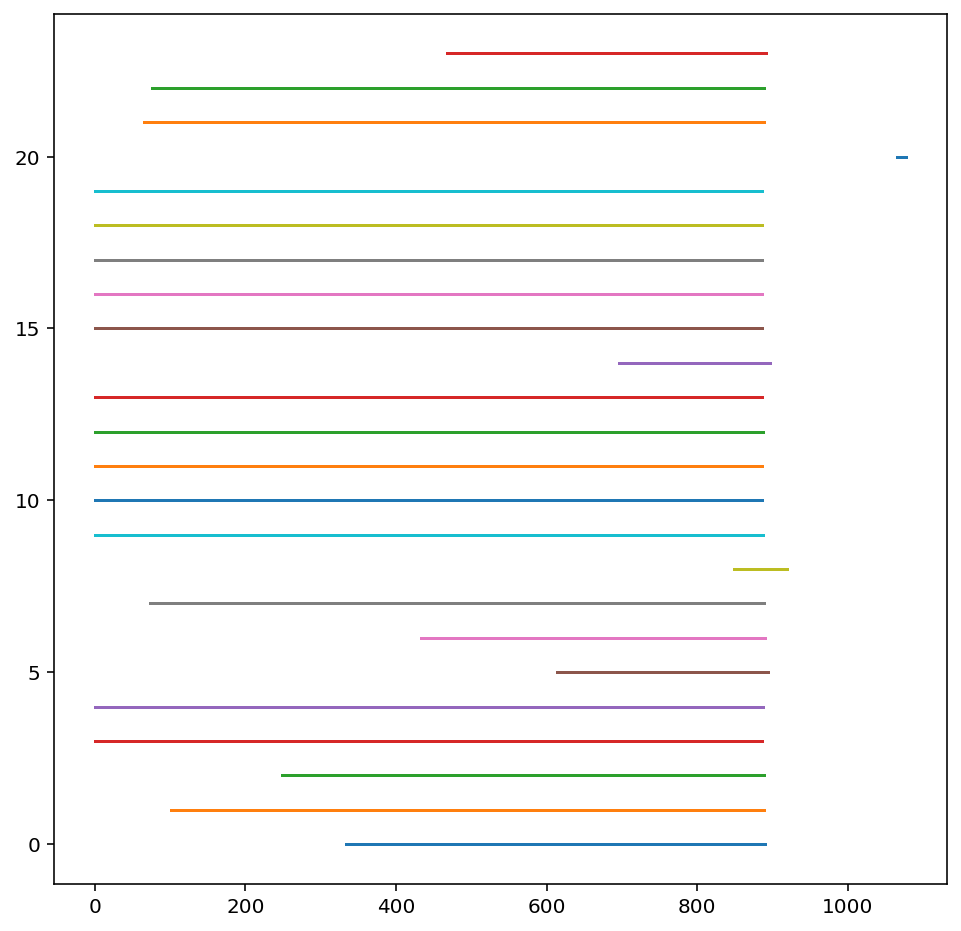

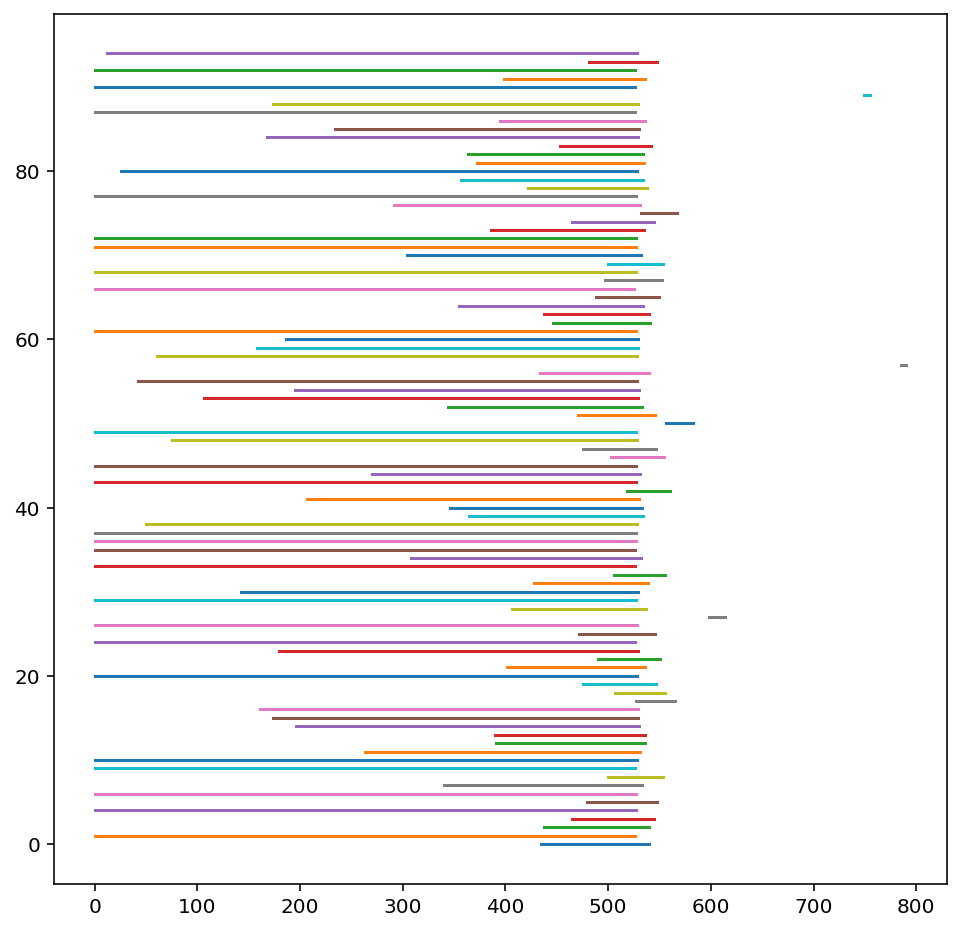

In [19]:
fig = plt.figure(figsize = (8, 8))
E_field = 1.0 # V/cm
drift_time = 25*60
n_strands = 1
L_DNA = 1e8
mean_breaks = 20

n_segs = np.zeros(n_strands).astype(int)

for n in range(0, n_strands):
    # 1
    n_breaks = rng.poisson(mean_breaks)
    n_segs[n] = n_breaks + 1
    seg_lengths = np.zeros(mean_breaks + 5*np.sqrt(mean_breaks).astype(int))
    drift_dist = np.zeros(max(n_segs))
    breaks = np.zeros(n_breaks)
    breaks = rng.uniform(0.0, 1.0, n_breaks)
    ends = np.zeros(n_segs[n] + 1)
    ends[1:n_segs[n]] = np.sort(breaks)
    ends[n_segs[n]] = 1.0
    seg_lengths[0:n_segs[n]] = L_DNA*(ends[1:n_segs[n] + 1] - ends[0:n_segs[n]])
    list_drift_dist = drift_dist[0:n_segs[n]]
    list_seg_lengths = seg_lengths[0:n_segs[n]]

    drift_dist[0:n_segs[n]] = vDagarose(seg_lengths[0:n_segs[n]]/1000, E_field)*drift_time # um

    bp_to_micro = 1e6*0.04/1e8
    y_offset = np.arange(n_segs[n])
    right = list_drift_dist
    left = np.maximum(right - list_seg_lengths*bp_to_micro, 0.0)
    #
    for n_seg in range(0, len(list_drift_dist)):
        plt.plot([left[n_seg], right[n_seg]], [y_offset[n_seg], y_offset[n_seg]])
    #
    
yVals = np.array([0.05, 0.15, 0.3, 0.5, 0.8, 1.0])
fig = plt.figure(figsize = (8, 8))
E_field = 0.8 # V/cm
drift_time = 20*60
n_strands = 1
L_DNA = 1e8
mean_breaks = 100

n_segs = np.zeros(n_strands).astype(int)

for n in range(0, n_strands):
    # 1
    n_breaks = rng.poisson(mean_breaks)
    n_segs[n] = n_breaks + 1
    seg_lengths = np.zeros(mean_breaks + 5*np.sqrt(mean_breaks).astype(int))
    drift_dist = np.zeros(max(n_segs))
    breaks = np.zeros(n_breaks)
    breaks = rng.uniform(0.0, 1.0, n_breaks)
    ends = np.zeros(n_segs[n] + 1)
    ends[1:n_segs[n]] = np.sort(breaks)
    ends[n_segs[n]] = 1.0
    seg_lengths[0:n_segs[n]] = L_DNA*(ends[1:n_segs[n] + 1] - ends[0:n_segs[n]])
    list_drift_dist = drift_dist[0:n_segs[n]]
    list_seg_lengths = seg_lengths[0:n_segs[n]]

    drift_dist[0:n_segs[n]] = vDagarose(seg_lengths[0:n_segs[n]]/1000, E_field)*drift_time # um

    bp_to_micro = 1e6*0.04/1e8
    y_offset = np.arange(n_segs[n])
    right = list_drift_dist
    left = np.maximum(right - list_seg_lengths*bp_to_micro, 0.0)
    #
    for n_seg in range(0, len(list_drift_dist)):
        plt.plot([left[n_seg], right[n_seg]], [y_offset[n_seg], y_offset[n_seg]])
    #

### Varying electric field strength

Segment drift for one strand of DNA with 100 mean breaks has been determined for 6 different electric field strengths. This is to demonstrate the relationship of electric field strength and strand mobility.


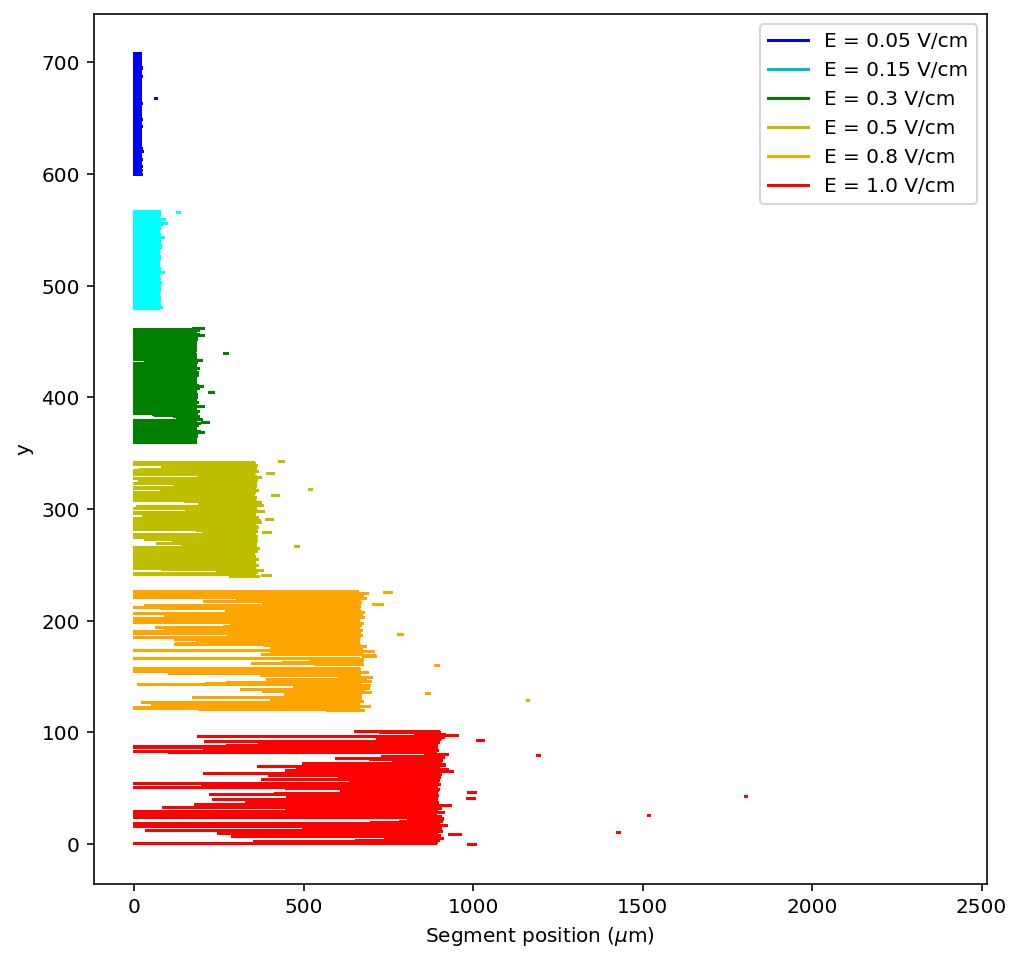

In [20]:
yVals = np.array([0.05, 0.15, 0.3, 0.5, 0.8, 1.0])
fig = plt.figure(figsize = (8, 8))
E_field = 1.0 # V/cm
drift_time = 25*60
n_strands = 1
L_DNA = 1e8
mean_breaks = 100

n_segs = np.zeros(n_strands).astype(int)

for n in range(0, n_strands):
    # 1
    n_breaks = rng.poisson(mean_breaks)
    n_segs[n] = n_breaks + 1
    seg_lengths = np.zeros(mean_breaks + 5*np.sqrt(mean_breaks).astype(int))
    drift_dist = np.zeros(max(n_segs))
    breaks = np.zeros(n_breaks)
    breaks = rng.uniform(0.0, 1.0, n_breaks)
    ends = np.zeros(n_segs[n] + 1)
    ends[1:n_segs[n]] = np.sort(breaks)
    ends[n_segs[n]] = 1.0
    seg_lengths[0:n_segs[n]] = L_DNA*(ends[1:n_segs[n] + 1] - ends[0:n_segs[n]])
    list_drift_dist = drift_dist[0:n_segs[n]]
    list_seg_lengths = seg_lengths[0:n_segs[n]]

    drift_dist[0:n_segs[n]] = vDagarose(seg_lengths[0:n_segs[n]]/1000, E_field)*drift_time # um

    bp_to_micro = 1e6*0.04/1e8
    y_offset = np.arange(n_segs[n])
    right = list_drift_dist
    left = np.maximum(right - list_seg_lengths*bp_to_micro, 0.0)
    #
    for n_seg in range(0, len(list_drift_dist)):
        plt.plot([left[n_seg], right[n_seg]], [y_offset[n_seg], y_offset[n_seg]], color = 'r')
    #
#
#
for n in range(0, n_strands):
    # 0.8
    n_breaks = rng.poisson(mean_breaks)
    n_segs[n] = n_breaks + 1
    seg_lengths = np.zeros(mean_breaks + 5*np.sqrt(mean_breaks).astype(int))
    drift_dist = np.zeros(max(n_segs))
    breaks = np.zeros(n_breaks)
    breaks = rng.uniform(0.0, 1.0, n_breaks)
    ends = np.zeros(n_segs[n] + 1)
    ends[1:n_segs[n]] = np.sort(breaks)
    ends[n_segs[n]] = 1.0
    seg_lengths[0:n_segs[n]] = L_DNA*(ends[1:n_segs[n] + 1] - ends[0:n_segs[n]])
    list_drift_dist = drift_dist[0:n_segs[n]]
    list_seg_lengths = seg_lengths[0:n_segs[n]]

    drift_dist[0:n_segs[n]] = vDagarose(seg_lengths[0:n_segs[n]]/1000, 0.8)*drift_time # um

    bp_to_micro = 1e6*0.04/1e8
    y_offset = np.arange(n_segs[n])+120
    right = list_drift_dist
    left = np.maximum(right - list_seg_lengths*bp_to_micro, 0.0)
    #
    for n_seg in range(0, len(list_drift_dist)):
        plt.plot([left[n_seg], right[n_seg]], [y_offset[n_seg], y_offset[n_seg]], color='orange')

for n in range(0, n_strands):
    # 0.5
    n_breaks = rng.poisson(mean_breaks)
    n_segs[n] = n_breaks + 1
    seg_lengths = np.zeros(mean_breaks + 5*np.sqrt(mean_breaks).astype(int))
    drift_dist = np.zeros(max(n_segs))
    breaks = np.zeros(n_breaks)
    breaks = rng.uniform(0.0, 1.0, n_breaks)
    ends = np.zeros(n_segs[n] + 1)
    ends[1:n_segs[n]] = np.sort(breaks)
    ends[n_segs[n]] = 1.0
    seg_lengths[0:n_segs[n]] = L_DNA*(ends[1:n_segs[n] + 1] - ends[0:n_segs[n]])
    list_drift_dist = drift_dist[0:n_segs[n]]
    list_seg_lengths = seg_lengths[0:n_segs[n]]

    drift_dist[0:n_segs[n]] = vDagarose(seg_lengths[0:n_segs[n]]/1000, 0.5)*drift_time # um

    bp_to_micro = 1e6*0.04/1e8
    y_offset = np.arange(n_segs[n])+240
    right = list_drift_dist
    left = np.maximum(right - list_seg_lengths*bp_to_micro, 0.0)
    #
    for n_seg in range(0, len(list_drift_dist)):
        plt.plot([left[n_seg], right[n_seg]], [y_offset[n_seg], y_offset[n_seg]], color='y')


for n in range(0, n_strands):
    # 0.3
    n_breaks = rng.poisson(mean_breaks)
    n_segs[n] = n_breaks + 1
    seg_lengths = np.zeros(mean_breaks + 5*np.sqrt(mean_breaks).astype(int))
    drift_dist = np.zeros(max(n_segs))
    breaks = np.zeros(n_breaks)
    breaks = rng.uniform(0.0, 1.0, n_breaks)
    ends = np.zeros(n_segs[n] + 1)
    ends[1:n_segs[n]] = np.sort(breaks)
    ends[n_segs[n]] = 1.0
    seg_lengths[0:n_segs[n]] = L_DNA*(ends[1:n_segs[n] + 1] - ends[0:n_segs[n]])
    list_drift_dist = drift_dist[0:n_segs[n]]
    list_seg_lengths = seg_lengths[0:n_segs[n]]

    drift_dist[0:n_segs[n]] = vDagarose(seg_lengths[0:n_segs[n]]/1000, 0.3)*drift_time # um

    bp_to_micro = 1e6*0.04/1e8
    y_offset = np.arange(n_segs[n])+360
    right = list_drift_dist
    left = np.maximum(right - list_seg_lengths*bp_to_micro, 0.0)
    #
    for n_seg in range(0, len(list_drift_dist)):
        plt.plot([left[n_seg], right[n_seg]], [y_offset[n_seg], y_offset[n_seg]], color='g')

for n in range(0, n_strands):
    # 0.15
    n_breaks = rng.poisson(mean_breaks)
    n_segs[n] = n_breaks + 1
    seg_lengths = np.zeros(mean_breaks + 5*np.sqrt(mean_breaks).astype(int))
    drift_dist = np.zeros(max(n_segs))
    breaks = np.zeros(n_breaks)
    breaks = rng.uniform(0.0, 1.0, n_breaks)
    ends = np.zeros(n_segs[n] + 1)
    ends[1:n_segs[n]] = np.sort(breaks)
    ends[n_segs[n]] = 1.0
    seg_lengths[0:n_segs[n]] = L_DNA*(ends[1:n_segs[n] + 1] - ends[0:n_segs[n]])
    list_drift_dist = drift_dist[0:n_segs[n]]
    list_seg_lengths = seg_lengths[0:n_segs[n]]

    drift_dist[0:n_segs[n]] = vDagarose(seg_lengths[0:n_segs[n]]/1000, 0.15)*drift_time # um

    bp_to_micro = 1e6*0.04/1e8
    y_offset = np.arange(n_segs[n])+480
    right = list_drift_dist
    left = np.maximum(right - list_seg_lengths*bp_to_micro, 0.0)
    #
    for n_seg in range(0, len(list_drift_dist)):
        plt.plot([left[n_seg], right[n_seg]], [y_offset[n_seg], y_offset[n_seg]], color='cyan')
    plt.plot(label='0.15')

for n in range(0, n_strands):
    # 0.05
    n_breaks = rng.poisson(mean_breaks)
    n_segs[n] = n_breaks + 1
    seg_lengths = np.zeros(mean_breaks + 5*np.sqrt(mean_breaks).astype(int))
    drift_dist = np.zeros(max(n_segs))
    breaks = np.zeros(n_breaks)
    breaks = rng.uniform(0.0, 1.0, n_breaks)
    ends = np.zeros(n_segs[n] + 1)
    ends[1:n_segs[n]] = np.sort(breaks)
    ends[n_segs[n]] = 1.0
    seg_lengths[0:n_segs[n]] = L_DNA*(ends[1:n_segs[n] + 1] - ends[0:n_segs[n]])
    list_drift_dist = drift_dist[0:n_segs[n]]
    list_seg_lengths = seg_lengths[0:n_segs[n]]

    drift_dist[0:n_segs[n]] = vDagarose(seg_lengths[0:n_segs[n]]/1000, 0.05)*drift_time # um

    bp_to_micro = 1e6*0.04/1e8
    y_offset = np.arange(n_segs[n])+600
    right = list_drift_dist
    left = np.maximum(right - list_seg_lengths*bp_to_micro, 0.0)
    #
    for n_seg in range(0, len(list_drift_dist)):
        plt.plot([left[n_seg], right[n_seg]], [y_offset[n_seg], y_offset[n_seg]], color='b')
    #plt.plot(label='0.05')
#
#plt.title('Segment vs drift distance')
plt.xlabel("Segment position ($\mu$m)")
plt.ylabel("y")
plt.plot(0,0, color='b', label='E = 0.05 V/cm')
plt.plot(0,0, color='c', label='E = 0.15 V/cm')
plt.plot(0,0, color='g', label='E = 0.3 V/cm')
plt.plot(0,0, color='y', label='E = 0.5 V/cm')
plt.plot(0,0, color='orange', label='E = 0.8 V/cm')
plt.plot(0,0, color='r', label='E = 1.0 V/cm')
plt.legend()
plt.savefig('varying_E_field')
plt.show()

## Two dimensional scatter plots for one cell

Here the transverse component has been included. It is also important to consider DNA strands and segments do not all start along the y axis, segments begin at the end of another. Here 0.8 V/cm has been used for 20 minutes.


In [11]:

def poisson_func(k, lam):
    '''
    Poisson distribution function.
    Given number of occurences and mean, returns distribution function value.
    '''
    poiss = lam**k*np.exp(-lam)/special.factorial(k)
    return poiss
#
def break_strands(n_strands, mean_breaks):
    '''
    Given number of DNA strands in cell and mean number of breaks per strand, return number of segments 
    each strand breaks into and the lengths of those segments in base-pairs.
    '''
    n_segs = np.zeros(n_strands).astype(int)
    seg_lens = np.zeros((n_strands, (mean_breaks + 5*np.sqrt(mean_breaks)).astype(int)))
    #
    for n in range(0, n_strands):
        n_breaks = rng.poisson(mean_breaks)
        breaks = np.zeros(n_breaks)
        breaks = rng.uniform(0.0, 1.0, n_breaks)
        n_segs[n] = n_breaks + 1
        ends = np.zeros(n_segs[n] + 1)
        ends[1:n_segs[n]] = np.sort(breaks)
        ends[n_segs[n]] = 1.0
        seg_lens[n, 0:n_segs[n]] = L_DNA_bp*(ends[1:n_segs[n] + 1] - ends[0:n_segs[n]])
    #
    return n_segs, seg_lens
#
bp_to_cm = 100*0.04/1e8
bp_to_mum = 1e6*0.04/1e8

#
# Number of (single) DNA strands
n_strands = 92
#
# Length of DNA strand
L_DNA_bp = 1e8 # base pairs
L_DNA_cm = 4.0 # cm
#
# Define image parameters and agarose depth
n_rows = 1040 # number of rows of pixels (y coord)
n_cols = 1392 # number of columns of pixels (x coord)
depth = 20 # depth of agarose in case optical simulation needed (z coord)
n_pixels = n_rows*n_cols
#
# Initialise random number generator
rng = np.random.default_rng(123)
#
# Average number of breaks per strand, the number of segments generated and their lengths
mean_breaks = 100 
#mean_breaks = 40
#
# Simulate breaks and segments for all strands
n_segs, seg_lens = break_strands(n_strands, mean_breaks)
#
# Set up histgram of number of breaks
num_range = np.zeros(2)
num_range[0] = np.maximum(mean_breaks - 5*np.sqrt(mean_breaks), 0.0).astype(int)
num_range[1] = (mean_breaks + 5*np.sqrt(mean_breaks)).astype(int)
n_num_bins = ((num_range[1] - num_range[0])).astype(int)
num_bins, num_bin_wid = np.linspace(num_range[0], num_range[1], n_num_bins + 1, retstep = True)
num_bin_cents = 0.5*(num_bins[0:n_num_bins] + num_bins[1:n_num_bins + 1])
num_bin_err = num_bin_wid/np.sqrt(12)*np.ones(n_num_bins)
cum_num_hist = np.zeros(n_num_bins)
#
# Set up histogram of segment lengths
n_len_bins = 40
len_bins, len_bin_wid = np.linspace(0.0, 10*L_DNA_bp/mean_breaks, n_len_bins + 1, retstep = True)
len_bin_cents = 0.5*(len_bins[0:n_len_bins] + len_bins[1:n_len_bins + 1])
len_bin_err = len_bin_wid/np.sqrt(12)*np.ones(n_len_bins)
cum_len_hist = np.zeros(n_len_bins)
#
# Fill histograms
for n in range(0, n_strands):
    #
    num_hist_here, _ = np.histogram(n_segs[n], num_bins)
    cum_num_hist += num_hist_here
    #
    len_hist_here, _ = np.histogram(seg_lens[n, 0:n_segs[n]], len_bins)
    cum_len_hist += len_hist_here
#
# Function describing distribution of number of breaks
n_poiss_plot = 100
k_poiss_plot = np.linspace(num_range[0], num_range[1], n_poiss_plot)
poiss_func_plot = n_strands*num_bin_wid*poisson_func(mean_breaks, k_poiss_plot)
#
# Function describing segment length distribution
len_func_plot = (mean_breaks*(mean_breaks + 1)*n_strands*
                 len_bin_wid/L_DNA_bp*np.exp(-mean_breaks*len_bin_cents/L_DNA_bp))
#
def init_cell_pos(n_cells):
    '''
    Given the number of cells, determine their imitial positions.
    '''
    x_cell = np.zeros(n_cells)
    y_cell = np.zeros(n_cells)
    z_cell = np.zeros(n_cells)
    #
    # Set location of cells
    if n_cells == 1:
        x_cell[0] = n_cols/2
        y_cell[0] = n_rows/2
        z_cell[0] = depth/2
    else:
        x_cell = np.random.uniform(0, n_cols, n_cells)
        y_cell = np.random.uniform(0, n_rows, n_cells)
        z_cell = np.random.uniform(0, depth, n_cells)
    #
    return x_cell, y_cell, z_cell
#
def init_strand_pos(n_strands):
    '''
    Determine the initial positions of the strands within a cell.
    '''
    use_sphere = True
    #
    # Simulate uniform radial and phi initial distribution of strands
    rad_arr = np.sqrt(np.random.uniform(0, max(np.random.normal(rad_cell, sig_rad_cell, 1),
                                               rad_cell_min)**2, n_strands))
    phi_arr = np.random.uniform(0, 2*np.pi, n_strands)
    #
    # Determine initial coordinates of strands (simulate uniform initial theta distribution if required)
    if use_sphere:
        theta_arr = np.arccos(np.random.uniform(-1, 1, n_strands))
        x_strand = rad_arr*np.sin(theta_arr)*np.cos(phi_arr)
        y_strand = rad_arr*np.sin(theta_arr)*np.sin(phi_arr)
        z_strand = rad_arr*np.cos(theta_arr)
    else:
        x_strand = rad_arr*np.cos(phi_arr)
        y_strand = rad_arr*np.sin(phi_arr)
        z_strand = np.random.uniform(0, depth, n_strands)
    #
    return x_strand, y_strand, z_strand
#
# Radius of nucleus
rad_nuc = 2.0 # microns
rad_nuc_min = 1.5 # microns
sig_rad_nuc = 0.5 # microns
#
# Radius of cell
rad_cell = 6.0 # microns
rad_cell_min = 4.0 # microns
sig_rad_cell = 1.0 # microns
#
# Color table for plots
n_color_tab = 8
color_tab = np.array(['r', 'orange', 'y', 'g', 'c', 'b', 'm', 'k'])
#
# Set up number of cells and their positions
n_cells = 15
x_cell, y_cell, z_cell = init_cell_pos(n_cells)
#
for n_cell in range(0, n_cells):
    #
    # Detemine and plot initial positions of all strands in image
    x_strand, y_strand, z_strand = init_strand_pos(n_strands)
    #
    col_inds = (np.linspace(0, n_strands - 1, n_strands)%n_color_tab).astype(int)
    #ax2d_pic.scatter(x_cell[n_cell] + x_strand, 
                     #y_cell[n_cell] + y_strand, color = color_tab[col_inds], s = 1.0)
    #ax3d_pic.scatter(x_cell[n_cell] + x_strand, 
                     #y_cell[n_cell] + y_strand, 
                     #z_cell[n_cell] + z_strand, color = color_tab[col_inds], s = 1.0)
    #
    if n_cell > 0:
        continue

#
#
def vDagarose(L, E):
    '''
    Given length of DNA strand (in kbp) and electric field (in V/cm) returns 
    velocity in agarose (units probably microns per sec). Fit to data in Zimm paper.
    '''
    if not hasattr(vDagarose, "kB"):
        vDagarose.kB, vDagarose.kC, vDagarose.kL, vDagarose.alpha = 2.24, 0.56, 0.59, 1.34
        #print(" ")
        #print("Parameters used to descibe vD in agarose")
        #print("kB = {:.2f}".format(vDagarose.kB))
        #print("kC = {:.2f}".format(vDagarose.kC))
        #print("kL = {:.2f}".format(vDagarose.kL))
        #print("alpha = {:.2f}".format(vDagarose.alpha))
    #
    #vD = (vDagarose.kB*E/(1 + vDagarose.kC*L) + vDagarose.kL*E**vDagarose.alpha)  # microns per sec.
    vD = (vDagarose.kB*E/(1 + vDagarose.kC*L))
    #
    return vD
#
def vDagaroseC(L, E):
    '''
    Given length of DNA strand (in kbp) and electric field (in V/cm) returns 
    velocity in agarose (units mm per hour). Fit to data from Calladine paper.
    '''
    if not hasattr(vDagaroseC, "kB"):
        vDagaroseC.kB, vDagaroseC.kC, vDagaroseC.kL, vDagaroseC.alpha = 2.68, 0.83, 5.83, -3.96
        #print(" ")
        #print("Parameters used to descibe vD in agarose")
        #print("kB = {:.2f}".format(vDagaroseC.kB))
        #print("kC = {:.2f}".format(vDagaroseC.kC))
        #print("kL = {:.2f}".format(vDagaroseC.kL))
        #print("alpha = {:.2f}".format(vDagaroseC.alpha))
    #
    vD = (vDagaroseC.kB*E/(1 + vDagaroseC.kC*L) + vDagaroseC.kL*E**vDagaroseC.alpha)  # mm per hour.
    #vD = (vDagaroseC.kB*E/(1 + vDagaroseC.kC*L))
    #
    return vD
#
# Calculate fitted function values x direction
nPlot = 100
xBot = 0.1
xTop = 1000.0
xPlot = np.exp(np.linspace(np.log(xBot), np.log(xTop), nPlot))
nY = 5
yVals = np.array([0.05, 0.15, 0.3, 0.5, 0.8, 1.0]) # V/cm
#
# Calculate fitted function values y direction
yBot = 0.0
yTop = 1.0
yPlot = np.linspace(yBot, yTop, nPlot)
nX = 11
xVals = np.array([0.31, 0.59, 0.86, 1.07, 1.28, 1.97, 2.24, 4.28, 6.59, 9.31, 23.01]) # kbp
#

nCol = 0
for plot in range(nY, 0, -1):
    fitPlotX = vDagarose(xPlot, yVals[plot - 1]*np.ones(nPlot))
    #fitPlotXC = vDagaroseC(xPlot, yVals[plot - 1]*np.ones(nPlot))
    #ax.plot(xPlot, fitPlotX, linestyle = '-', color = color_tab[nCol%n_color_tab], 
     #       label = "E = " + str(yVals[plot - 1]) + " V/cm")
    #ax.plot(xPlot, fitPlotXC, linestyle = '--', color = color_tab[nCol%n_color_tab])
    nCol += 1

nCol = 0
for plot in range(0, nX):
    fitPlotY = vDagarose(xVals[plot]*np.ones(nPlot), yPlot)
    #fitPlotYC = vDagaroseC(xVals[plot]*np.ones(nPlot), yPlot)
    #ax.plot(yPlot, fitPlotY, linestyle = '-', color = color_tab[nCol%n_color_tab],
            #label = "Len = " + str(xVals[plot]) + " kbp")
    #ax.plot(yPlot, fitPlotYC, linestyle = '--', color = color_tab[nCol%n_color_tab])
    nCol += 1

seg_vels = np.zeros((n_strands, np.amax(n_segs).astype(int)))
seg_drifts = np.zeros((n_strands, np.amax(n_segs).astype(int)))
#
E_field = 0.8 # V/cm
drift_time = 20*60 # secs
#

#
# Calculate velocities and distance
for n in range(0, n_strands):
    #
    # Convert lengths from bp to kbp!
    seg_vels[n, 0:n_segs[n]] = vDagarose(seg_lens[n, 0:n_segs[n]]/1000, E_field) # microns per second
    #
    seg_drifts[n, 0:n_segs[n]] = seg_vels[n, 0:n_segs[n]]*drift_time # microns
#
# Set up histogram of drift velocities and distances
n_vel_bins = 40
vel_bins, vel_bin_wid = np.linspace(0.0, 1.1*np.amax(seg_vels), n_vel_bins + 1, retstep = True)
vel_bin_cents = 0.5*(vel_bins[0:n_vel_bins] + vel_bins[1:n_vel_bins + 1])
vel_bin_err = vel_bin_wid/np.sqrt(12)*np.ones(n_vel_bins)
cum_vel_hist = np.zeros(n_vel_bins)
#
n_drift_bins = 40
drift_bins, drift_bin_wid = np.linspace(0.0, 1.1*np.amax(seg_drifts), n_drift_bins + 1, retstep = True)
drift_bin_cents = 0.5*(drift_bins[0:n_drift_bins] + drift_bins[1:n_drift_bins + 1])
drift_bin_err = drift_bin_wid/np.sqrt(12)*np.ones(n_drift_bins)
cum_drift_hist = np.zeros(n_drift_bins)
#
# Fill histograms
for n in range(0, n_strands):
    vel_hist_here, _ = np.histogram(seg_vels[n, 0:n_segs[n]], vel_bins)
    cum_vel_hist += vel_hist_here
    #
    drift_hist_here, _ = np.histogram(seg_drifts[n, 0:n_segs[n]], drift_bins)
    cum_drift_hist += drift_hist_here
#
#
# First make plots to check image
n_strand = 1
#
x_beg = x_strand[n_strand] + np.maximum(seg_drifts[n_strand, 0:n_segs[n_strand]] - 
                                        seg_lens[n_strand, 0:n_segs[n_strand]]*bp_to_mum, 0.0)
x_end = x_strand[n_strand] + seg_drifts[n_strand, 0:n_segs[n_strand]]
#
# Plot with arbitrary (linearly increasing) y value
y_beg = np.linspace(0, n_segs[n_strand] - 1, n_segs[n_strand])
y_end = y_beg



Date and time  2023-05-09 11:09:52.164446


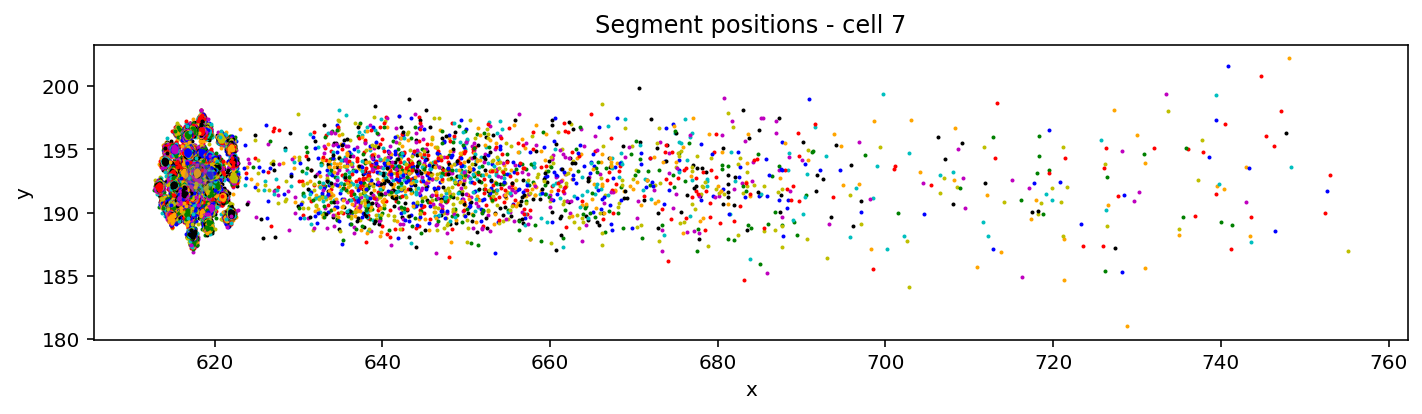

 
Date and time 2023-05-09 11:12:38.122553
Time since last check is 0:02:45.958107


In [12]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import sys
#
n_cell = 7
max_strands_plot = 100
#
# n_figs = 1 (x, y) plot; n_figs = 2 (x, y) and (x, z) plots; n_figs = 3 (x, y), (x, z) and (y, z) plots 
n_figs = 1
#
def fill_seg(x0, y0, z0, vel, drift, length):
    '''
    Given the length, start and end positions of a segment, return the positions of the points 
    from which fluourescence light is emitted.
    '''
    #rho_fluor = 4.0
    rho_fluor = 0.1
    sig_fluor_x = 0.5*np.sqrt(vel)
    sig_fluor_head = 2.0*np.sqrt(vel)
    sig_fluor_tail = 3.0*np.sqrt(vel)
    #
    # Beginning of strand, displaced from x0 if length less than drift!
    x_beg = x0 + np.maximum(drift - length, 0.0)
    y_beg = y0
    z_beg = z0
    #
    # End of strand
    x_end = x0 + drift
    y_end = y0
    z_end = z0
    #
    # Total fluorescence from strand
    n_fluor = int(length*rho_fluor)
    #
    # Fluorescence from tail
    len_tail = np.sqrt((x_beg - x_end)**2 + (y_beg - y_end)**2 + (z_beg - z_end)**2)
    n_tail = int(len_tail*rho_fluor)
    #
    # Fluorescence from head, zero if entire strand length is in tail!
    n_head = n_fluor - n_tail
    #
    # Length of any gap between x0 and rear of tail and gap "fluorescence" needed to calculate transverse 
    # motion during drift
    l_gap = max(drift - length, 0.0)
    n_gap = int(l_gap*rho_fluor)
    #
    # Random additions to positions of fluorescence: x coords
    x_add = np.zeros(n_fluor)
    x_add[0:n_head] = rng.normal(0.0, sig_fluor_head, n_head)
    x_add[n_head:n_fluor] = rng.normal(0.0, sig_fluor_x, n_tail)
    #
    # y coords, need to allow for transverse motion if there is a gap between x0 and rear end of tail
    y_add = np.zeros(n_fluor)
    y_add[0:n_head] = rng.normal(0.0, sig_fluor_head, n_head)
    if n_gap > 0:
        y_gap = np.cumsum(rng.normal(0.0, sig_fluor_tail, n_gap))[n_gap - 1]
    else:
        y_gap = 0.0
    y_add[n_head:n_fluor] = y_gap + np.cumsum(rng.normal(0.0, sig_fluor_tail, n_tail))
    #
    # z coords
    z_add = np.zeros(n_fluor)
    z_add[0:n_head] = rng.normal(0.0, sig_fluor_head, n_head)
    if n_gap > 0:
        z_gap = np.cumsum(rng.normal(0.0, sig_fluor_tail, n_gap))[n_gap - 1]
    else:
        z_gap = 0.0
    z_add[n_head:n_fluor] = z_gap + np.cumsum(rng.normal(0.0, sig_fluor_tail, n_tail))
    #
    x_fluor = np.zeros(n_fluor)
    x_fluor[0:n_head] = x_beg + x_add[0:n_head]
    x_fluor[n_head:n_fluor] = x_beg + (x_end - x_beg)*np.linspace(0, 1, n_tail) + x_add[n_head:n_fluor]
    #
    y_fluor = np.zeros(n_fluor)
    y_fluor = y_beg + y_add
    #
    z_fluor = np.zeros(n_fluor)
    z_fluor = z_beg + z_add
    #
    return n_fluor, x_fluor, y_fluor, z_fluor
#
# Plot initial positions of all strands in image
fig = plt.figure(figsize = (10, 3*n_figs))
#
if n_figs > 0:
    xy_cell = fig.add_subplot(n_figs, 1, 1)
    xy_cell.set_title("Segment positions - cell " + str(n_cell))
    xy_cell.set_xlabel("x")
    xy_cell.set_ylabel("y")
if n_figs > 1:
    xz_cell = fig.add_subplot(n_figs, 1, 2)
    xz_cell.set_title("Segment positions - cell " + str(n_cell))
    xz_cell.set_xlabel("x")
    xz_cell.set_ylabel("z")
if n_figs > 2:
    yz_cell = fig.add_subplot(n_figs, 1, 3)
    yz_cell.set_title("Segment positions - cell " + str(n_cell))
    yz_cell.set_xlabel("y")
    yz_cell.set_ylabel("z")
if n_figs > 3:
    print(" ")
    print("Unexpected n_figs value",n_figs)
#
max_photons = 500000
n_photons = 0
x_photons = np.zeros(max_photons)
y_photons = np.zeros(max_photons)
z_photons = np.zeros(max_photons)
#
for n_strand in range(0, min(n_strands, max_strands_plot)):
    #
    # Set up colour table indices for plotting
    col_inds = (np.linspace(0, n_segs[n_strand] - 1, n_segs[n_strand])%n_color_tab).astype(int)
    #
    for n_seg in range(0, n_segs[n_strand]):
        #
        n_fluor, x_fluor, y_fluor, z_fluor = fill_seg(x_cell[n_cell] + x_strand[n_strand], 
                                                      y_cell[n_cell] + y_strand[n_strand],
                                                      z_cell[n_cell] + z_strand[n_strand],
                                                      seg_vels[n_strand, n_seg],
                                                      seg_drifts[n_strand, n_seg],
                                                      seg_lens[n_strand, n_seg]*bp_to_mum)
        #
        if n_figs > 0:
            xy_cell.scatter(x_fluor[0:n_fluor], y_fluor[0:n_fluor], color = color_tab[col_inds[n_seg]], s = 1.0)
        if n_figs > 1:
            xz_cell.scatter(x_fluor[0:n_fluor], z_fluor[0:n_fluor], color = color_tab[col_inds[n_seg]], s = 1.0)
        if n_figs > 2:
            yz_cell.scatter(y_fluor[0:n_fluor], z_fluor[0:n_fluor], color = color_tab[col_inds[n_seg]], s = 1.0)
        #
        if n_photons + n_fluor >= max_photons:
            print(" ")
            print("Maximum storable photon number exceeded, stop")
            sys.exit(0)
        #
        x_photons[n_photons:n_photons + n_fluor] = x_fluor[0:n_fluor]
        y_photons[n_photons:n_photons + n_fluor] = y_fluor[0:n_fluor]
        z_photons[n_photons:n_photons + n_fluor] = z_fluor[0:n_fluor]
        n_photons += n_fluor
    #
x_photons = x_photons[0:n_photons]
y_photons = y_photons[0:n_photons]
z_photons = z_photons[0:n_photons]
#
if n_figs > 0:
    xy_cell.scatter(x_cell[n_cell], y_cell[n_cell], color = 'grey', s = 200.0, alpha = 0.3)
if n_figs > 1:
    xz_cell.scatter(x_cell[n_cell], z_cell[n_cell], color = 'grey', s = 200.0, alpha = 0.3)
if n_figs > 2:
    yz_cell.scatter(y_cell[n_cell], z_cell[n_cell], color = 'grey', s = 200.0, alpha = 0.3)
#
plt.tight_layout()
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

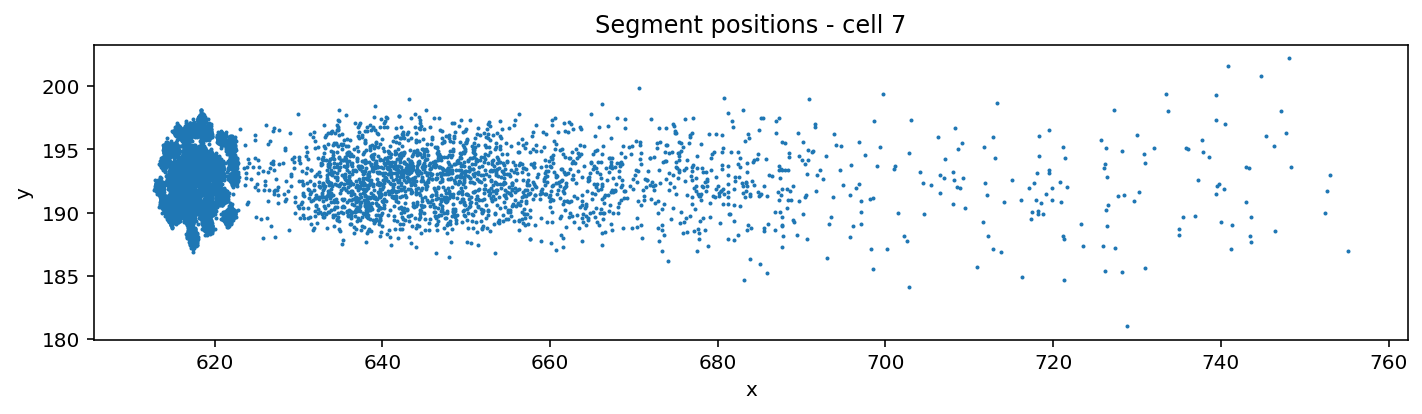

In [13]:
fig = plt.figure(figsize = (10, 3*n_figs))
#
xy_cell = fig.add_subplot(n_figs, 1, 1)
xy_cell.set_title("Segment positions - cell " + str(n_cell))
xy_cell.set_xlabel("x")
xy_cell.set_ylabel("y")
xy_cell.scatter(x_photons, y_photons, s = 1.0)
#
plt.tight_layout()
plt.show()

## Image for one cell

This is a final model representing an image of the cell under a microscope. The bright circular head and dimmer tail is shown. The model has room for improvement as there is a slight gap in between the head and tail, moving forward parameters need to be optimised across the model.


Date and time  2023-05-09 11:12:52.981552
 
Total fluorescence signal 363336.00
Fluorescence signal per pixel 3.03
Dynamic range 28.00 dB or 25.12.
Minimum exposure 0.03 maximum 19.01.
 


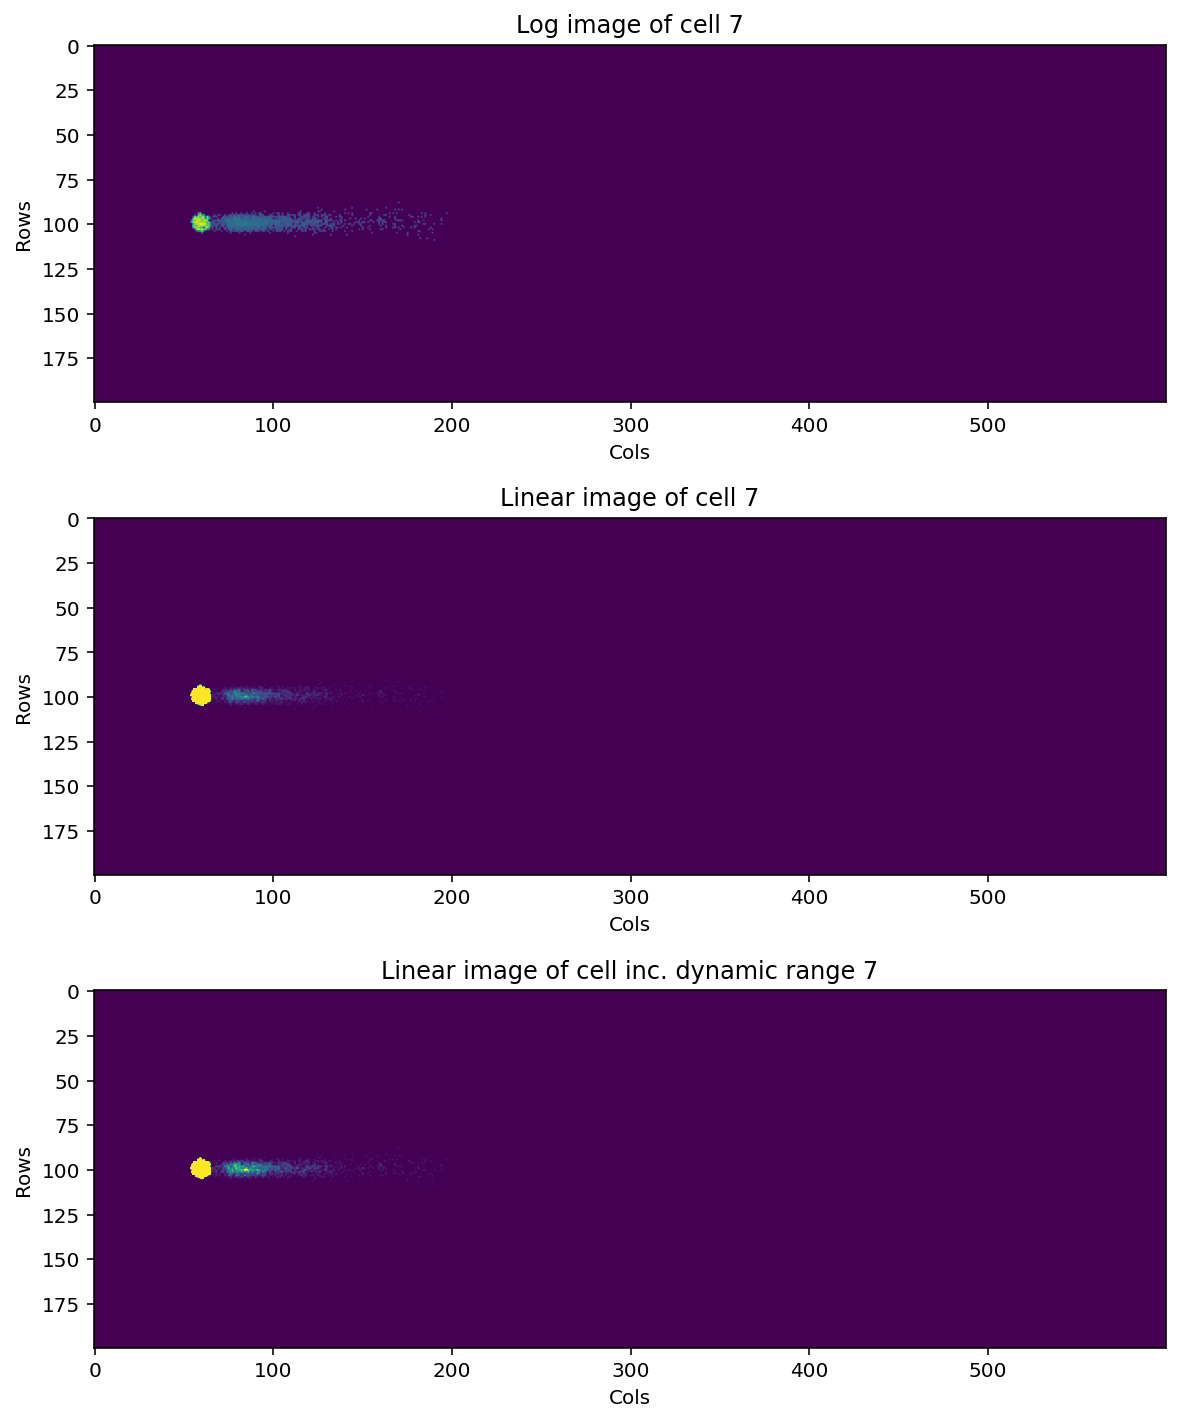

 
Date and time 2023-05-09 11:12:53.828605
Time since last check is 0:00:00.847053


In [14]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
full_frame = False
#
# Image dimensions
if full_frame:
    n_rows = 1040 # number of rows of pixels (y coord)
    n_cols = 1392 # number of columns of pixels (x coord)
    row_bot, row_top = 0.0, 1000.0
    col_bot, col_top = 0.0, 1000.0
else:
    n_rows = 200 # number of rows of pixels (y coord)
    n_cols = 600 # number of columns of pixels (x coord)
    row_bot, row_top = y_cell[n_cell] - n_rows/2, y_cell[n_cell] + n_rows/2
    col_bot, col_top = x_cell[n_cell] - 0.1*n_cols, x_cell[n_cell] + 0.9*n_cols
#
cell_image = np.zeros((n_rows, n_cols))
row_edges = np.linspace(row_bot, row_top, n_rows + 1)
col_edges = np.linspace(col_bot, col_top, n_cols + 1)
#
# Add photons to appropriate pixels
cell_image, _, _ = np.histogram2d(y_photons, x_photons, bins = (row_edges, col_edges))
#
# Plot initial positions of all strands in image
n_pix_here = n_rows*n_cols
fluor_total = np.sum(cell_image)
fluor_per_pixel = fluor_total/n_pix_here
#
v_min = np.amin(cell_image)
v_max = 0.001*np.amax(cell_image)
#
dyn_range_dB = 28
dyn_range = 10**(dyn_range_dB/20)
#
v_fluor_min = (fluor_per_pixel/2)/dyn_range/2
v_fluor_max = (fluor_per_pixel/2)*dyn_range/2
#
print(" ")
print(f"Total fluorescence signal {fluor_total:.2f}")
print(f"Fluorescence signal per pixel {fluor_per_pixel:.2f}")
print(f"Dynamic range {dyn_range_dB:.2f} dB or {dyn_range:.2f}.")
print(f"Minimum exposure {v_fluor_min:.2f} maximum {v_fluor_max:.2f}.")
print(" ")
#
fig = plt.figure(figsize = (18, 10))
#
im_cell = fig.add_subplot(3, 1, 1)
im_cell.set_title("Log image of cell " + str(n_cell))
im_cell.set_xlabel("Cols")
im_cell.set_ylabel("Rows")
im_cell.imshow(np.log(cell_image + 0.1))
#
im_cell = fig.add_subplot(3, 1, 2)
im_cell.set_title("Linear image of cell " + str(n_cell))
im_cell.set_xlabel("Cols")
im_cell.set_ylabel("Rows")
im_cell.imshow(cell_image, vmin = v_min, vmax = v_max)
#
im_cell = fig.add_subplot(3, 1, 3)
im_cell.set_title("Linear image of cell inc. dynamic range " + str(n_cell))
im_cell.set_xlabel("Cols")
im_cell.set_ylabel("Rows")
im_cell.imshow(cell_image, vmin = v_fluor_min, vmax = v_fluor_max)
#
plt.tight_layout()
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time  2023-05-09 11:14:27.404632


 
Maximum storable photon number exceeded, stop


SystemExit: 0

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


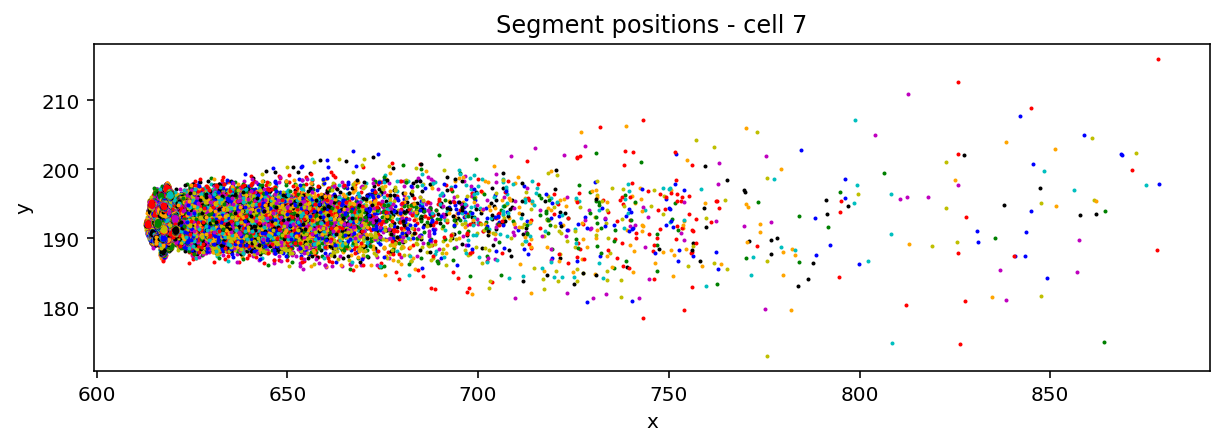

In [15]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import sys
#
n_cell = 7
max_strands_plot = 100
#
# n_figs = 1 (x, y) plot; n_figs = 2 (x, y) and (x, z) plots; n_figs = 3 (x, y), (x, z) and (y, z) plots 
n_figs = 1
#
def fill_seg(x0, y0, z0, vel, drift, length):
    '''
    Given the length, start and end positions of a segment, return the positions of the points 
    from which fluourescence light is emitted.
    '''
    #rho_fluor = 4.0
    rho_fluor = 0.2
    sig_fluor_x = 0.5*np.sqrt(vel)
    sig_fluor_head = 2.0*np.sqrt(vel)
    sig_fluor_tail = 3.0*np.sqrt(vel)
    #
    # Beginning of strand, displaced from x0 if length less than drift!
    x_beg = x0 + np.maximum(drift - length, 0.0)
    y_beg = y0
    z_beg = z0
    #
    # End of strand
    x_end = x0 + drift
    y_end = y0
    z_end = z0
    #
    # Total fluorescence from strand
    n_fluor = int(length*rho_fluor)
    #
    # Fluorescence from tail
    len_tail = np.sqrt((x_beg - x_end)**2 + (y_beg - y_end)**2 + (z_beg - z_end)**2)
    n_tail = int(len_tail*rho_fluor)
    #
    # Fluorescence from head, zero if entire strand length is in tail!
    n_head = n_fluor - n_tail
    #
    # Length of any gap between x0 and rear of tail and gap "fluorescence" needed to calculate transverse 
    # motion during drift
    l_gap = max(drift - length, 0.0)
    n_gap = int(l_gap*rho_fluor)
    #
    # Random additions to positions of fluorescence: x coords
    x_add = np.zeros(n_fluor)
    x_add[0:n_head] = rng.normal(0.0, sig_fluor_head, n_head)
    x_add[n_head:n_fluor] = rng.normal(0.0, sig_fluor_x, n_tail)
    #
    # y coords, need to allow for transverse motion if there is a gap between x0 and rear end of tail
    y_add = np.zeros(n_fluor)
    y_add[0:n_head] = rng.normal(0.0, sig_fluor_head, n_head)
    if n_gap > 0:
        y_gap = np.cumsum(rng.normal(0.0, sig_fluor_tail, n_gap))[n_gap - 1]
    else:
        y_gap = 0.0
    y_add[n_head:n_fluor] = y_gap + np.cumsum(rng.normal(0.0, sig_fluor_tail, n_tail))
    #
    # z coords
    z_add = np.zeros(n_fluor)
    z_add[0:n_head] = rng.normal(0.0, sig_fluor_head, n_head)
    if n_gap > 0:
        z_gap = np.cumsum(rng.normal(0.0, sig_fluor_tail, n_gap))[n_gap - 1]
    else:
        z_gap = 0.0
    z_add[n_head:n_fluor] = z_gap + np.cumsum(rng.normal(0.0, sig_fluor_tail, n_tail))
    #
    x_fluor = np.zeros(n_fluor)
    x_fluor[0:n_head] = x_beg + x_add[0:n_head]
    x_fluor[n_head:n_fluor] = x_beg + (x_end - x_beg)*np.linspace(0, 1, n_tail) + x_add[n_head:n_fluor]
    #
    y_fluor = np.zeros(n_fluor)
    y_fluor = y_beg + y_add
    #
    z_fluor = np.zeros(n_fluor)
    z_fluor = z_beg + z_add
    #
    return n_fluor, x_fluor, y_fluor, z_fluor
#
# Plot initial positions of all strands in image
fig = plt.figure(figsize = (10, 3*n_figs))
#
if n_figs > 0:
    xy_cell = fig.add_subplot(n_figs, 1, 1)
    xy_cell.set_title("Segment positions - cell " + str(n_cell))
    xy_cell.set_xlabel("x")
    xy_cell.set_ylabel("y")
if n_figs > 1:
    xz_cell = fig.add_subplot(n_figs, 1, 2)
    xz_cell.set_title("Segment positions - cell " + str(n_cell))
    xz_cell.set_xlabel("x")
    xz_cell.set_ylabel("z")
if n_figs > 2:
    yz_cell = fig.add_subplot(n_figs, 1, 3)
    yz_cell.set_title("Segment positions - cell " + str(n_cell))
    yz_cell.set_xlabel("y")
    yz_cell.set_ylabel("z")
if n_figs > 3:
    print(" ")
    print("Unexpected n_figs value",n_figs)
#
max_photons = 1000000
n_photons = 0
x_photons = np.zeros(max_photons)
y_photons = np.zeros(max_photons)
z_photons = np.zeros(max_photons)
#
for x in range(0, 5):
    for n_strand in range(0, min(n_strands, max_strands_plot)):
        #
        # Set up colour table indices for plotting
        col_inds = (np.linspace(0, n_segs[n_strand] - 1, n_segs[n_strand])%n_color_tab).astype(int)
        #
        for n_seg in range(0, n_segs[n_strand]):
            #
            n_fluor, x_fluor, y_fluor, z_fluor = fill_seg(x_cell[n_cell] + x_strand[n_strand], 
                                                          y_cell[n_cell] + y_strand[n_strand],
                                                          z_cell[n_cell] + z_strand[n_strand],
                                                          seg_vels[n_strand, n_seg],
                                                          seg_drifts[n_strand, n_seg],
                                                          seg_lens[n_strand, n_seg]*bp_to_mum)
            #
            if n_figs > 0:
                xy_cell.scatter(x_fluor[0:n_fluor], y_fluor[0:n_fluor], color = color_tab[col_inds[n_seg]], s = 1.0)
            if n_figs > 1:
                xz_cell.scatter(x_fluor[0:n_fluor], z_fluor[0:n_fluor], color = color_tab[col_inds[n_seg]], s = 1.0)
            if n_figs > 2:
                yz_cell.scatter(y_fluor[0:n_fluor], z_fluor[0:n_fluor], color = color_tab[col_inds[n_seg]], s = 1.0)
            #
            if n_photons + n_fluor >= max_photons:
                print(" ")
                print("Maximum storable photon number exceeded, stop")
                sys.exit(0)
            #
            x_photons[n_photons:n_photons + n_fluor] = x_fluor[0:n_fluor]
            y_photons[n_photons:n_photons + n_fluor] = y_fluor[0:n_fluor]
            z_photons[n_photons:n_photons + n_fluor] = z_fluor[0:n_fluor]
            n_photons += n_fluor
    #
x_photons = x_photons[0:n_photons]
y_photons = y_photons[0:n_photons]
z_photons = z_photons[0:n_photons]
#
if n_figs > 0:
    xy_cell.scatter(x_cell[n_cell], y_cell[n_cell], color = 'grey', s = 200.0, alpha = 0.3)
if n_figs > 1:
    xz_cell.scatter(x_cell[n_cell], z_cell[n_cell], color = 'grey', s = 200.0, alpha = 0.3)
if n_figs > 2:
    yz_cell.scatter(y_cell[n_cell], z_cell[n_cell], color = 'grey', s = 200.0, alpha = 0.3)
#
plt.tight_layout()
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import sys
#
n_cell = 7
max_strands_plot = 100
#
# n_figs = 1 (x, y) plot; n_figs = 2 (x, y) and (x, z) plots; n_figs = 3 (x, y), (x, z) and (y, z) plots 
n_figs = 1
#
def fill_seg(x0, y0, z0, vel, drift, length):
    '''
    Given the length, start and end positions of a segment, return the positions of the points 
    from which fluourescence light is emitted.
    '''
    #rho_fluor = 4.0
    rho_fluor = 0.2
    sig_fluor_x = 0.5*np.sqrt(vel)
    sig_fluor_head = 2.0*np.sqrt(vel)
    sig_fluor_tail = 3.0*np.sqrt(vel)
    #
    # Beginning of strand, displaced from x0 if length less than drift!
    x_beg = x0 + np.maximum(drift - length, 0.0)
    y_beg = y0
    z_beg = z0
    #
    # End of strand
    x_end = x0 + drift
    y_end = y0
    z_end = z0
    #
    # Total fluorescence from strand
    n_fluor = int(length*rho_fluor)
    #
    # Fluorescence from tail
    len_tail = np.sqrt((x_beg - x_end)**2 + (y_beg - y_end)**2 + (z_beg - z_end)**2)
    n_tail = int(len_tail*rho_fluor)
    #
    # Fluorescence from head, zero if entire strand length is in tail!
    n_head = n_fluor - n_tail
    #
    # Length of any gap between x0 and rear of tail and gap "fluorescence" needed to calculate transverse 
    # motion during drift
    l_gap = max(drift - length, 0.0)
    n_gap = int(l_gap*rho_fluor)
    #
    # Random additions to positions of fluorescence: x coords
    x_add = np.zeros(n_fluor)
    x_add[0:n_head] = rng.normal(0.0, sig_fluor_head, n_head)
    x_add[n_head:n_fluor] = rng.normal(0.0, sig_fluor_x, n_tail)
    #
    # y coords, need to allow for transverse motion if there is a gap between x0 and rear end of tail
    y_add = np.zeros(n_fluor)
    y_add[0:n_head] = rng.normal(0.0, sig_fluor_head, n_head)
    if n_gap > 0:
        y_gap = np.cumsum(rng.normal(0.0, sig_fluor_tail, n_gap))[n_gap - 1]
    else:
        y_gap = 0.0
    y_add[n_head:n_fluor] = y_gap + np.cumsum(rng.normal(0.0, sig_fluor_tail, n_tail))
    #
    # z coords
    z_add = np.zeros(n_fluor)
    z_add[0:n_head] = rng.normal(0.0, sig_fluor_head, n_head)
    if n_gap > 0:
        z_gap = np.cumsum(rng.normal(0.0, sig_fluor_tail, n_gap))[n_gap - 1]
    else:
        z_gap = 0.0
    z_add[n_head:n_fluor] = z_gap + np.cumsum(rng.normal(0.0, sig_fluor_tail, n_tail))
    #
    x_fluor = np.zeros(n_fluor)
    x_fluor[0:n_head] = x_beg + x_add[0:n_head]
    x_fluor[n_head:n_fluor] = x_beg + (x_end - x_beg)*np.linspace(0, 1, n_tail) + x_add[n_head:n_fluor]
    #
    y_fluor = np.zeros(n_fluor)
    y_fluor = y_beg + y_add
    #
    z_fluor = np.zeros(n_fluor)
    z_fluor = z_beg + z_add
    #
    return n_fluor, x_fluor, y_fluor, z_fluor
#
# Plot initial positions of all strands in image
fig = plt.figure(figsize = (10, 3*n_figs))
#
if n_figs > 0:
    xy_cell = fig.add_subplot(n_figs, 1, 1)
    xy_cell.set_title("Segment positions - cell " + str(n_cell))
    xy_cell.set_xlabel("x")
    xy_cell.set_ylabel("y")
if n_figs > 1:
    xz_cell = fig.add_subplot(n_figs, 1, 2)
    xz_cell.set_title("Segment positions - cell " + str(n_cell))
    xz_cell.set_xlabel("x")
    xz_cell.set_ylabel("z")
if n_figs > 2:
    yz_cell = fig.add_subplot(n_figs, 1, 3)
    yz_cell.set_title("Segment positions - cell " + str(n_cell))
    yz_cell.set_xlabel("y")
    yz_cell.set_ylabel("z")
if n_figs > 3:
    print(" ")
    print("Unexpected n_figs value",n_figs)
#
max_photons = 1000000
n_photons = 0
x_photons = np.zeros(max_photons)
y_photons = np.zeros(max_photons)
z_photons = np.zeros(max_photons)
#
for x in range(0, 5):
    for n_strand in range(0, min(n_strands, max_strands_plot)):
        #
        # Set up colour table indices for plotting
        col_inds = (np.linspace(0, n_segs[n_strand] - 1, n_segs[n_strand])%n_color_tab).astype(int)
        #
        for n_seg in range(0, n_segs[n_strand]):
            #
            n_fluor, x_fluor, y_fluor, z_fluor = fill_seg(x_cell[n_cell] + x_strand[n_strand], 
                                                          y_cell[n_cell] + y_strand[n_strand],
                                                          z_cell[n_cell] + z_strand[n_strand],
                                                          seg_vels[n_strand, n_seg],
                                                          seg_drifts[n_strand, n_seg],
                                                          seg_lens[n_strand, n_seg]*bp_to_mum)
            #
            if n_figs > 0:
                xy_cell.scatter(x_fluor[0:n_fluor], y_fluor[0:n_fluor], color = color_tab[col_inds[n_seg]], s = 1.0)
            if n_figs > 1:
                xz_cell.scatter(x_fluor[0:n_fluor], z_fluor[0:n_fluor], color = color_tab[col_inds[n_seg]], s = 1.0)
            if n_figs > 2:
                yz_cell.scatter(y_fluor[0:n_fluor], z_fluor[0:n_fluor], color = color_tab[col_inds[n_seg]], s = 1.0)
            #
            if n_photons + n_fluor >= max_photons:
                print(" ")
                print("Maximum storable photon number exceeded, stop")
                sys.exit(0)
            #
            x_photons[n_photons:n_photons + n_fluor] = x_fluor[0:n_fluor]
            y_photons[n_photons:n_photons + n_fluor] = y_fluor[0:n_fluor]
            z_photons[n_photons:n_photons + n_fluor] = z_fluor[0:n_fluor]
            n_photons += n_fluor
    #
x_photons = x_photons[0:n_photons]
y_photons = y_photons[0:n_photons]
z_photons = z_photons[0:n_photons]
#
if n_figs > 0:
    xy_cell.scatter(x_cell[n_cell], y_cell[n_cell], color = 'grey', s = 200.0, alpha = 0.3)
if n_figs > 1:
    xz_cell.scatter(x_cell[n_cell], z_cell[n_cell], color = 'grey', s = 200.0, alpha = 0.3)
if n_figs > 2:
    yz_cell.scatter(y_cell[n_cell], z_cell[n_cell], color = 'grey', s = 200.0, alpha = 0.3)
#
plt.tight_layout()
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))